In [66]:
import json
import parser

# Read job description and resumes text from uploaded files
with open('File/Job.txt', 'r', encoding='utf-8') as f:
    job_desc = f.read()

with open('File/Resume.txt', 'r', encoding='utf-8') as f:
    resumes_text = f.read()

# Parse using parser.py
job_dict = parser.parse_job_description(job_desc)
resumes_list = parser.parse_resumes_text(resumes_text)

# print as JSON 
print("Parsed Job Description:")
print(json.dumps(job_dict, indent=2))

print("\nParsed Resumes (list):")
print(json.dumps(resumes_list, indent=2))


Parsed Job Description:
{
  "job_title": "Machine Learning Intern",
  "company": "Sprouts AI",
  "location": "San Francisco, CA",
  "job_description": "Sprouts AI is a startup that combines great UX and machine learning to deliver a whole new kind of tax filing experience. This is a ten-week internship position, with an expected start date of September 15, 2025. The role requires presence in the SF office (Financial District) at least one or more days per week.",
  "role_overview": "As a Machine Learning Intern, you will help build user-friendly features powered by LLMs (Large Language Models).",
  "responsibilities": [
    "Design and execute experiments using Python, Pandas, Weights & Biases, MySQL, and LLMs.",
    "Train, test, and deploy state-of-the-art machine learning models in production.",
    "Work with staff machine learning engineers to find technical solutions for complex business problems.",
    "Communicate clearly across mediums and functions (experiment write-ups, code

# Sematic Score Dictionary

In [67]:
import uuid
import json

job_id = "job_2025_001"
run_id = f"{uuid.uuid4().hex[:6]}"

results_dict = {}

for r in resumes_list:
    resume_id = r.get("resume_id") or r.get("candidate_name") or str(uuid.uuid4())
    results_dict[resume_id] = {
        "job_id": job_id,
        "resume_id": resume_id,
        "run_id": run_id,
        "education_score": None,
        "skills_score": None,
        "project_score": None,
        "experience_score": None,  
        "composite": None,
        "rank": None
    }

# results_dict JSON 
for resume_id, data in results_dict.items():
    print(f"Resume ID: {resume_id}")
    print(json.dumps(data, indent=2))



Resume ID: resume-1
{
  "job_id": "job_2025_001",
  "resume_id": "resume-1",
  "run_id": "8dcd1e",
  "education_score": null,
  "skills_score": null,
  "project_score": null,
  "experience_score": null,
  "composite": null,
  "rank": null
}
Resume ID: resume-2
{
  "job_id": "job_2025_001",
  "resume_id": "resume-2",
  "run_id": "8dcd1e",
  "education_score": null,
  "skills_score": null,
  "project_score": null,
  "experience_score": null,
  "composite": null,
  "rank": null
}
Resume ID: resume-3
{
  "job_id": "job_2025_001",
  "resume_id": "resume-3",
  "run_id": "8dcd1e",
  "education_score": null,
  "skills_score": null,
  "project_score": null,
  "experience_score": null,
  "composite": null,
  "rank": null
}
Resume ID: resume-4
{
  "job_id": "job_2025_001",
  "resume_id": "resume-4",
  "run_id": "8dcd1e",
  "education_score": null,
  "skills_score": null,
  "project_score": null,
  "experience_score": null,
  "composite": null,
  "rank": null
}
Resume ID: resume-5
{
  "job_id": "j

# Calculate Education Sematic score

In [68]:
# pip install sentence-transformers if needed
# %pip install -q sentence-transformers

import re
import json
import numpy as np
from typing import List, Tuple, Dict, Any
from sentence_transformers import SentenceTransformer

# Helpers & Patterns

# Single degree token (used for findall across the text)
DEGREE_TOKEN = r"(?:Bachelor(?:'s)?|Master(?:'s)?|Ph\.?\s?D\.?|M\.?\s?S\.?|B\.?\s?S\.?|BSc|MSc|BE|ME|BTech|MTech|B\.?\s?Eng|M\.?\s?Eng|MBA)"
DEGREE_TOKEN_RE = re.compile(DEGREE_TOKEN, re.IGNORECASE)

def normalize_text(x: str) -> str:
    return re.sub(r"\s+", " ", (x or "").strip())

def split_fields(fields_text: str) -> List[str]:
    """
    Split 'Computer Science, Data Science, or related fields'
    into ['Computer Science', 'Data Science', 'related fields'].
    Handles commas, 'and', 'or', slash.
    """
    if not fields_text:
        return []
    t = re.sub(r"\s*(?:\band\b|\bor\b|/)\s*", ",", fields_text, flags=re.IGNORECASE)
    parts = [normalize_text(p) for p in t.split(",")]
    cleaned = [re.sub(r"[.;]+$", "", p).strip() for p in parts if p.strip()]
    return cleaned

def extract_job_degrees_fields(qual_text: str) -> Tuple[List[str], List[str]]:
    """
    Robustly extract lists of degrees and fields from Qualifications text.
      "M.S./B.E./Ph.D. in Computer Science, Data Science, or related fields"
      -> degrees = ["M.S.", "B.E.", "Ph.D."]
         fields  = ["Computer Science", "Data Science", "related fields"]
    """
    if not qual_text:
        return [], []

    text = qual_text.strip()

    # 1) Fields: everything after first "in"
    m_in = re.search(r"\bin\b\s+([^.;\n]+)", text, flags=re.IGNORECASE)
    fields_text = m_in.group(1) if m_in else ""
    job_fields = split_fields(fields_text)

    # 2) Degrees: collect ALL degree tokens, preferably before "in"
    degrees_region = text[:m_in.start()] if m_in else text
    job_degrees = DEGREE_TOKEN_RE.findall(degrees_region)

    # Canonicalize & dedupe preserving order
    seen = set()
    degs = []
    for d in job_degrees:
        dd = normalize_text(d)
        if dd.lower() not in seen:
            seen.add(dd.lower())
            degs.append(dd)

    return degs, job_fields

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    # assume normalized embeddings
    return float(np.dot(a, b))

# Model (E5)
# "query:" for both sides for symmetry.
model = SentenceTransformer("intfloat/e5-base-v2")

def encode_texts(texts: List[str]) -> np.ndarray:
    texts = [f"query: {normalize_text(t)}" if t else "query: " for t in texts]
    return model.encode(texts, normalize_embeddings=True, convert_to_numpy=True)


# Build job degree & field lists and encode
job_qual = job_dict.get("qualifications", "")
job_degrees, job_fields = extract_job_degrees_fields(job_qual)

print("Parsed Job Requirements (Degrees & Fields)")
print("Degrees:", job_degrees or ["[none found]"])
print("Fields: ", job_fields  or ["[none found]"])
print()

# Pre-encode job degrees and fields for efficiency
job_deg_embs = encode_texts(job_degrees or [""])
job_fld_embs = encode_texts(job_fields  or [""])

# Scoring
def score_education_against_job(degree_text: str, field_text: str) -> float:
    """
    For one candidate education row:
      - degree score = max cosine vs all job degrees
      - field score  = max cosine vs all job fields
      - final = average (you can reweight)
    """
    if not (degree_text or field_text):
        return 0.0

    d_sim = 0.0
    f_sim = 0.0

    if degree_text:
        cand_deg_emb = encode_texts([degree_text])[0]
        d_sim = max(
            cosine_sim(cand_deg_emb, job_deg_embs[i]) for i in range(job_deg_embs.shape[0])
        ) if job_deg_embs.size else 0.0

    if field_text:
        cand_fld_emb = encode_texts([field_text])[0]
        f_sim = max(
            cosine_sim(cand_fld_emb, job_fld_embs[i]) for i in range(job_fld_embs.shape[0])
        ) if job_fld_embs.size else 0.0

    if degree_text and field_text:
        return (d_sim + f_sim) / 2.0
    elif degree_text:
        return d_sim
    else:
        return f_sim

# Run scoring for each candidate education row
print("Candidate Education Match Scores")

# Accumulate scores BY RESUME ID (fix)
rid_to_scores: Dict[str, list] = {}
rid_to_name: Dict[str, str] = {}

for r in resumes_list:
    rid = r.get("resume_id", "")
    name = r.get("candidate_name", "Unknown")
    rid_to_scores.setdefault(rid, [])
    rid_to_name[rid] = name

    print(f"\nCandidate: {name}")
    edus = r.get("education", []) or []
    if not edus:
        print("  [No education entries]")
        continue

    for idx, edu in enumerate(edus, 1):
        deg = normalize_text(edu.get("degree", ""))
        fld = normalize_text(edu.get("field", ""))
        score = score_education_against_job(deg, fld)
        rid_to_scores[rid].append(score)

        print(f"  Education {idx}:")
        print(f"    Degree: {deg or '[NA]'}")
        print(f"    Field:  {fld or '[NA]'}")
        print(f"    Match Score: {score:.3f}")

# Overall averages + Leaderboard
print("\nOverall Education Semantic Score (Per Candidate)")
overall_scores = []  # list of (rid, avg, name)
for rid, scores in rid_to_scores.items():
    avg = float(np.mean(scores)) if scores else 0.0
    name = rid_to_name.get(rid, rid)
    overall_scores.append((rid, avg, name))
    print(f"{name}: {avg:.3f}")

print("\nLeaderboard (Education Score: High to Low)")
for rid, avg, name in sorted(overall_scores, key=lambda x: (-x[1], x[2].lower())):
    print(f"{name} ({rid}): {avg:.3f}")

# Update results_dict with education_score (by resume_id)
missing_keys = []
for rid, avg, name in overall_scores:
    if rid in results_dict:
        results_dict[rid]["education_score"] = avg
        # store candidate_name for convenience in future updates
        results_dict[rid]["candidate_name"] = name
    else:
        missing_keys.append(rid)

if missing_keys:
    print("\n[WARN] The following resume_ids were not found in results_dict and were not updated:")
    for rid in missing_keys:
        print("  -", rid)

# Print updated results_dict
print("\n=Updated results_dict")
for resume_id, data in results_dict.items():
    print(f"Resume ID: {resume_id}")
    print(json.dumps(data, indent=2))


Parsed Job Requirements (Degrees & Fields)
Degrees: ['M.S.', 'Ph.D.']
Fields:  ['Computer Science', 'Data Science', 'related field']

Candidate Education Match Scores

Candidate: Wesley Chen
  Education 1:
    Degree: M.S. Electrical Engineering (Computer Engineering)
    Field:  Computer Engineering
    Match Score: 0.908
  Education 2:
    Degree: B.S. Computer Engineering | Music Minor
    Field:  Computer Engineering, Music
    Match Score: 0.837

Candidate: Jinshuang Niu
  Education 1:
    Degree: M.S. in Computer Software Engineering
    Field:  Computer Software Engineering
    Match Score: 0.881

Candidate: Aparna Suresh
  Education 1:
    Degree: Master of Science in Computer Science
    Field:  Computer Science
    Match Score: 0.902
  Education 2:
    Degree: BTech in Computer Science and Engineering
    Field:  Computer Science and Engineering
    Match Score: 0.866

Candidate: Prashant Gupta
  Education 1:
    Degree: Master of Science in Software Engineering
    Field:  S

# Calculate Experience Sematic Scores

In [69]:
# Extract job responsibilities + candidate experiences

import re

def normalize_text(x: str) -> str:
    return re.sub(r"\s+", " ", (x or "").strip())

def format_list(lines):
    return [normalize_text(l) for l in (lines or []) if normalize_text(l)]

# 1) Job responsibilities (list of strings)
job_responsibilities = format_list(job_dict.get("responsibilities", []))

print("Job Responsibilities")
if not job_responsibilities:
    print("[None found]")
else:
    for i, r in enumerate(job_responsibilities, 1):
        print(f"{i}. {r}")

# 2) Resume experiences (structured + a concatenated profile string per candidate)
resume_experiences = {}      # resume_id -> list of experience dicts (company, position, duration, skills, work_description)
experience_profiles = {}     # resume_id -> single long text for semantic matching

print("\nCandidate Experiences")
for r in resumes_list:
    rid = r.get("resume_id", "")
    name = r.get("candidate_name", "Unknown")
    exps = r.get("experience", []) or []

    # Store structured experience rows
    items = []
    # Build a single text profile for embeddings later
    profile_parts = []

    print(f"\nCandidate: {name}  (resume_id={rid})")
    if not exps:
        print("  [No experience entries]")
        resume_experiences[rid] = []
        experience_profiles[rid] = ""
        continue

    for idx, exp in enumerate(exps, 1):
        company = normalize_text(exp.get("company", ""))
        position = normalize_text(exp.get("position", ""))
        duration = normalize_text(exp.get("duration", ""))
        skills   = [s for s in (exp.get("skills") or []) if normalize_text(s)]
        bullets  = format_list(exp.get("work_description", []))

        print(f"  Experience {idx}:")
        if company:  print(f"    Company:  {company}")
        if position: print(f"    Position: {position}")
        if duration: print(f"    Duration: {duration}")
        if skills:   print(f"    Skills:   {', '.join(skills)}")
        if bullets:
            print("    Work Description:")
            for b in bullets:
                print(f"      - {b}")

        # Save structured item
        items.append({
            "company": company,
            "position": position,
            "duration": duration,
            "skills": skills,
            "work_description": bullets
        })

        # Add to profile text
        if position or company:
            profile_parts.append(f"{position} at {company}".strip())
        if duration:
            profile_parts.append(duration)
        if bullets:
            profile_parts.extend(bullets)
        if skills:
            profile_parts.append(", ".join(skills))

    resume_experiences[rid] = items
    experience_profiles[rid] = " | ".join([p for p in profile_parts if p])
    


Job Responsibilities
1. Design and execute experiments using Python, Pandas, Weights & Biases, MySQL, and LLMs.
2. Train, test, and deploy state-of-the-art machine learning models in production.
3. Work with staff machine learning engineers to find technical solutions for complex business problems.
4. Communicate clearly across mediums and functions (experiment write-ups, code reviews, company-wide presentations).

Candidate Experiences

Candidate: Wesley Chen  (resume_id=resume-1)
  Experience 1:
    Company:  Snap Inc.
    Position: Software Engineering Intern, Snap AI Platform
    Duration: June 2021 – September 2021
    Skills:   Python, ML, Data Pipeline
    Work Description:
      - Worked in Python to improve the ML data pipeline by investigating performance of training data file formats and libraries.
      - Showed that consuming Parquet file format over TFRecord file format can bring up to 25x I/O efficiency gains in pipeline.
      - Produced POCs to replace an intermediate 

Job Responsibilities (bullets)
1. Design and execute experiments using Python, Pandas, Weights & Biases, MySQL, and LLMs.
2. Train, test, and deploy state-of-the-art machine learning models in production.
3. Work with staff machine learning engineers to find technical solutions for complex business problems.
4. Communicate clearly across mediums and functions (experiment write-ups, code reviews, company-wide presentations).

Concatenated Job Responsibilities (single text)
Design and execute experiments using Python, Pandas, Weights & Biases, MySQL, and LLMs. Train, test, and deploy state-of-the-art machine learning models in production. Work with staff machine learning engineers to find technical solutions for complex business problems. Communicate clearly across mediums and functions (experiment write-ups, code reviews, company-wide presentations).

Candidate Experiences (per experience concatenated)

Candidate: Wesley Chen (resume_id=resume-1)
  Exp 1: Software Engineering Intern, Sn

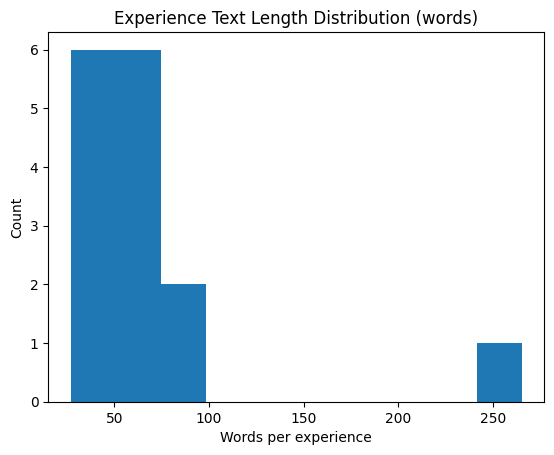

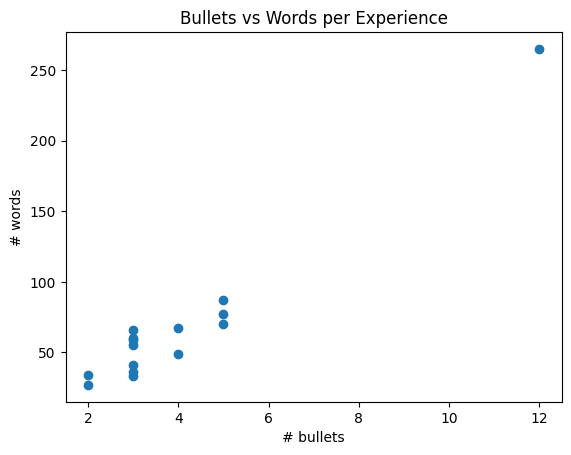

In [70]:
# Build & inspect texts

import re
from typing import List, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

def normalize_text(x: str) -> str:
    return re.sub(r"\s+", " ", (x or "").strip())

def concat_sentences(parts: List[str]) -> str:
    parts = [normalize_text(p) for p in (parts or []) if normalize_text(p)]
    return " ".join(parts)

# 1) Job responsibilities
job_responsibilities_list = job_dict.get("responsibilities", []) or []
job_responsibilities_text = concat_sentences(job_responsibilities_list)

print("Job Responsibilities (bullets)")
for i, r in enumerate(job_responsibilities_list, 1):
    print(f"{i}. {r}")

print("\nConcatenated Job Responsibilities (single text)")
print(job_responsibilities_text)

# 2) Per-resume, per-experience text (concatenated bullets)
resume_exp_texts: Dict[str, List[Dict[str, Any]]] = {}
summary_lengths = []  # for simple analysis: number of bullets & approx words

print("\nCandidate Experiences (per experience concatenated)")
for res in resumes_list:
    rid = res.get("resume_id", "")
    name = res.get("candidate_name", "Unknown")
    exps = []
    print(f"\nCandidate: {name} (resume_id={rid})")

    for i, exp in enumerate(res.get("experience", []) or []):
        bullets = exp.get("work_description", []) or []
        text = concat_sentences(bullets)
        exps.append({
            "exp_index": i+1,
            "text": text,
            "duration": exp.get("duration",""),
            "company": exp.get("company",""),
            "position": exp.get("position",""),
            "num_bullets": len([b for b in bullets if normalize_text(b)]),
            "n_words": len(text.split())
        })
        print(f"  Exp {i+1}: {exp.get('position','')} @ {exp.get('company','')}")
        print(f"    Duration: {exp.get('duration','')}")
        print(f"    Bullets: {len(bullets)} | Words: {len(text.split())}")
        print(f"    Text: {text[:200]}{'...' if len(text)>200 else ''}")
    resume_exp_texts[rid] = exps
    for e in exps:
        summary_lengths.append((rid, name, e["exp_index"], e["num_bullets"], e["n_words"]))

# Visuals
# A) Histogram of experience text length (words)
plt.figure()
plt.hist([x[4] for x in summary_lengths], bins=10)
plt.title("Experience Text Length Distribution (words)")
plt.xlabel("Words per experience")
plt.ylabel("Count")
plt.show()

# B) Scatter: bullets vs words (how verbose each exp is)
xs = [x[3] for x in summary_lengths]
ys = [x[4] for x in summary_lengths]
plt.figure()
plt.scatter(xs, ys)
plt.title("Bullets vs Words per Experience")
plt.xlabel("# bullets")
plt.ylabel("# words")
plt.show()


Raw semantic similarity (Job Responsibilities vs Experience)

Wesley Chen (resume-1)
  Exp 1: raw score = 0.825
  Exp 2: raw score = 0.812
  Exp 3: raw score = 0.809
  Exp 4: raw score = 0.818


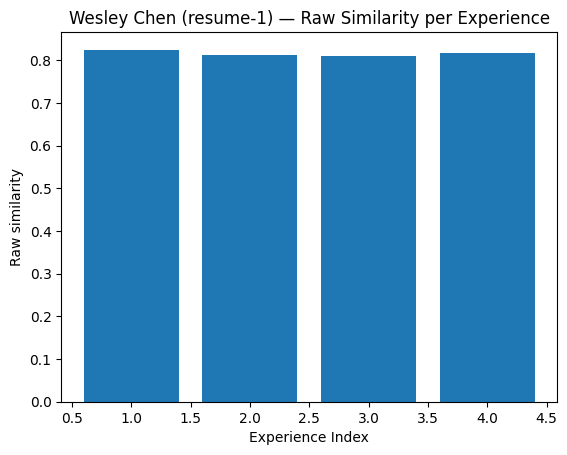

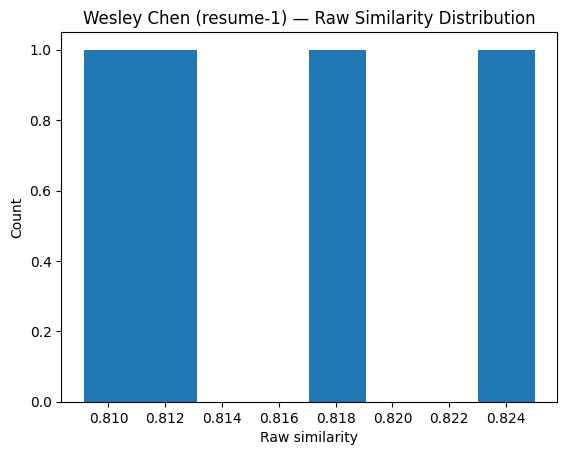


Jinshuang Niu (resume-2)
  Exp 1: raw score = 0.824
  Exp 2: raw score = 0.841


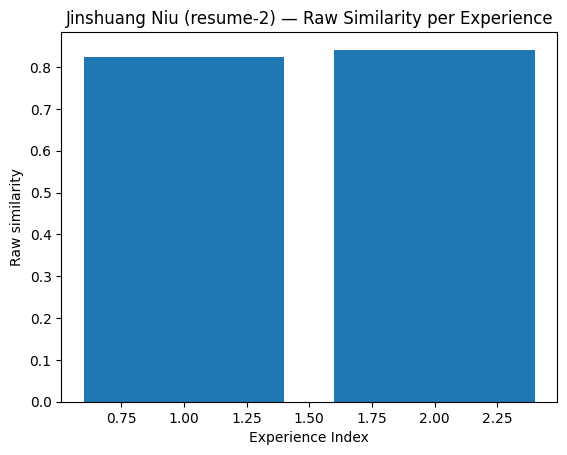

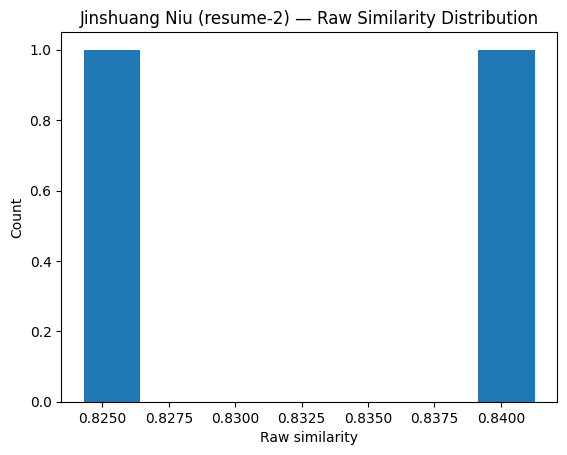


Aparna Suresh (resume-3)
  Exp 1: raw score = 0.802
  Exp 2: raw score = 0.847
  Exp 3: raw score = 0.819


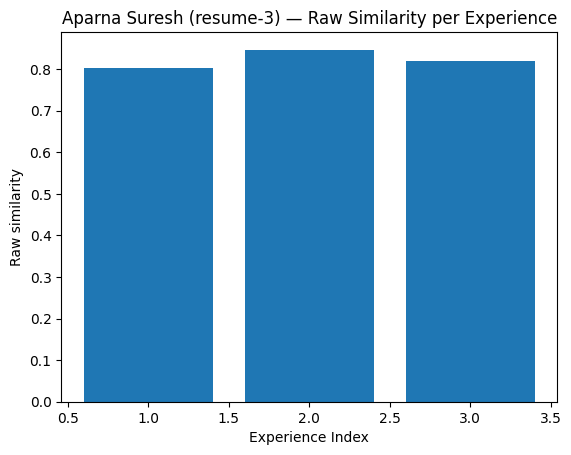

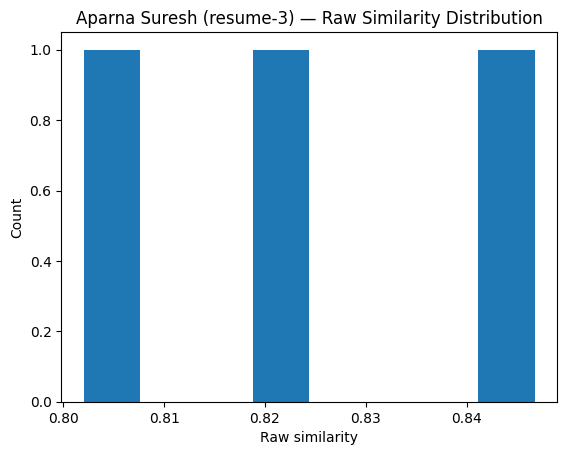


Prashant Gupta (resume-4)
  Exp 1: raw score = 0.820


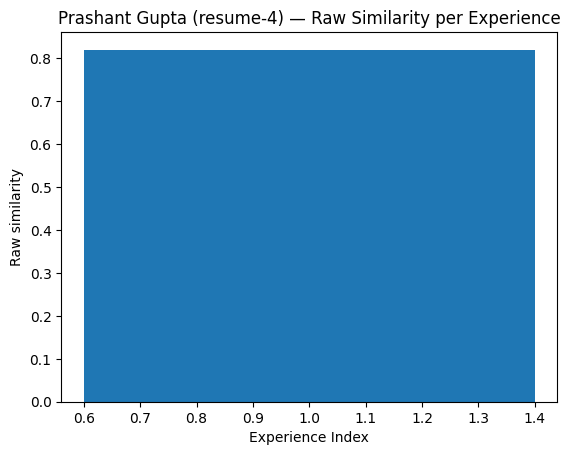

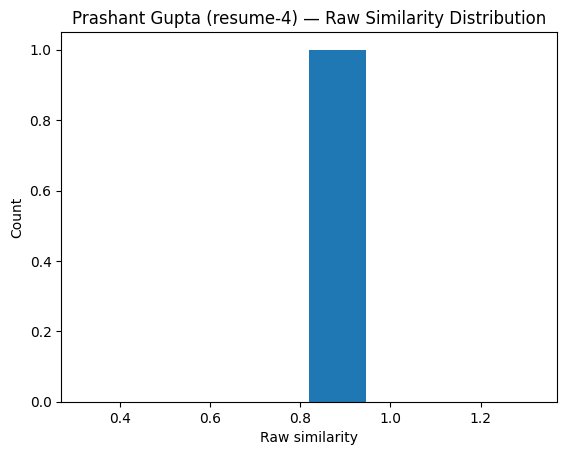


Harini S. (resume-5)
  Exp 1: raw score = 0.826
  Exp 2: raw score = 0.853
  Exp 3: raw score = 0.834


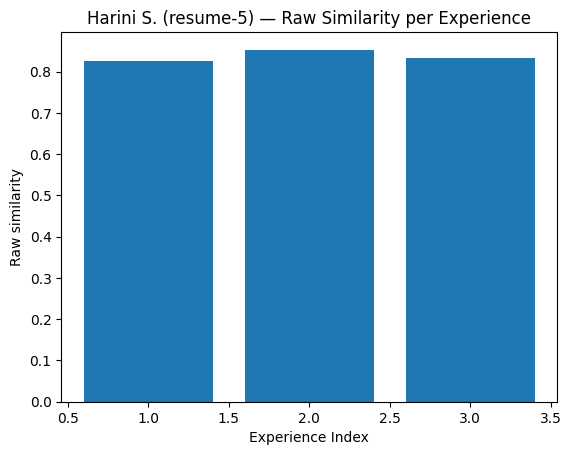

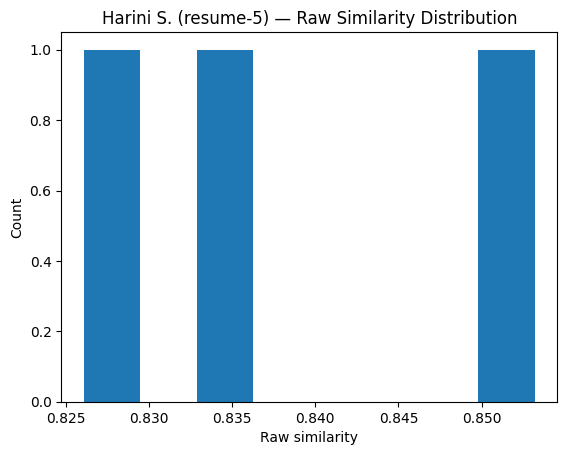


Shruti Verma (resume-6)
  Exp 1: raw score = 0.825
  Exp 2: raw score = 0.800


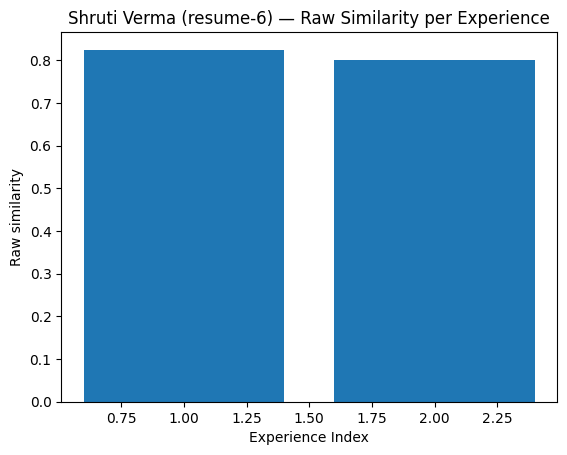

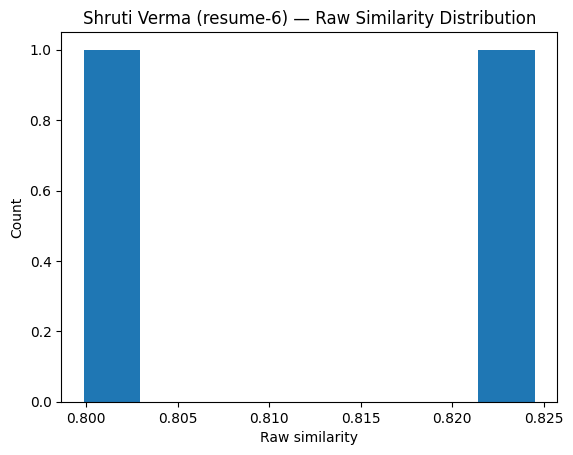

In [71]:
# Embed & compute raw semantic scores (Job vs Each Experience)

from sentence_transformers import SentenceTransformer

def encode_batch(model, texts):
    texts = [f"query: {normalize_text(t)}" for t in texts]
    return model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

# Load E5 once here (reuse in later cells if you keep this kernel)
model = SentenceTransformer("intfloat/e5-base-v2")

job_emb = encode_batch(model, [job_responsibilities_text])[0]

raw_scores_per_resume: Dict[str, Dict[str, Any]] = {}

print("Raw semantic similarity (Job Responsibilities vs Experience)")
for res in resumes_list:
    rid = res.get("resume_id","")
    name = res.get("candidate_name","Unknown")
    items = resume_exp_texts.get(rid, [])
    texts = [it["text"] for it in items]
    if not texts:
        raw_scores_per_resume[rid] = {"candidate_name": name, "raw": []}
        print(f"\n{name} ({rid}): [No experiences]")
        continue

    exp_embs = encode_batch(model, texts)          
    sims = np.dot(exp_embs, job_emb)               
    raw_scores_per_resume[rid] = {"candidate_name": name, "raw": sims.tolist()}

    print(f"\n{name} ({rid})")
    for i, s in enumerate(sims, 1):
        print(f"  Exp {i}: raw score = {float(s):.3f}")

    # Visuals per resume
    # 1) Bar chart of raw scores per experience
    plt.figure()
    plt.bar(range(1, len(sims)+1), sims)
    plt.title(f"{name} ({rid}) — Raw Similarity per Experience")
    plt.xlabel("Experience Index")
    plt.ylabel("Raw similarity")
    plt.show()

    # 2) Histogram of raw scores for this resume
    plt.figure()
    plt.hist(sims, bins=8)
    plt.title(f"{name} ({rid}) — Raw Similarity Distribution")
    plt.xlabel("Raw similarity")
    plt.ylabel("Count")
    plt.show()


Top ≤3 Experiences BEFORE Recency (by raw score)

Wesley Chen (resume-1) — avg top-3 raw = 0.818
  Exp 1: Software Engineering Intern, Snap AI Platform @ Snap Inc. | raw=0.825 | June 2021 – September 2021
  Exp 4: Intern, Test Engineer @ Vocera Communications | raw=0.818 | June 2018 – September 2018
  Exp 2: iOS Software Engineering Intern, Games/Minis Features @ Snap Inc. | raw=0.812 | June 2020 – September 2020

Jinshuang Niu (resume-2) — avg top-3 raw = 0.833
  Exp 2: Full-stack Software Engineer Intern @ Climate LLC | raw=0.841 | May 2022 – Aug 2022 (3 mos)
  Exp 1: Software Engineer @ Accolade, Inc. | raw=0.824 | June 2023 – Present (1 yr 9 mos)

Aparna Suresh (resume-3) — avg top-3 raw = 0.823
  Exp 2: Associate Software Engineer, Big Data @ LogMeIn | raw=0.847 | Jan 2020 - Jul 2021
  Exp 3: Associate Software Intern @ Morgan Stanley | raw=0.819 | Jun 2019 - Jul 2019
  Exp 1: Software Engineering Intern, Apache Spark @ NVIDIA | raw=0.802 | May 2022 - Aug 2022

Prashant Gupta (res

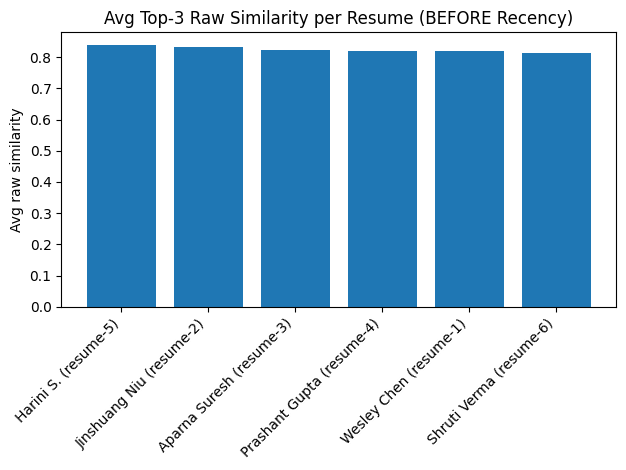

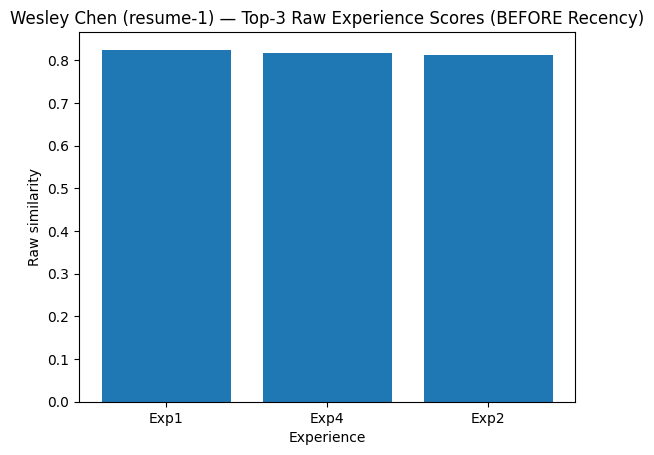

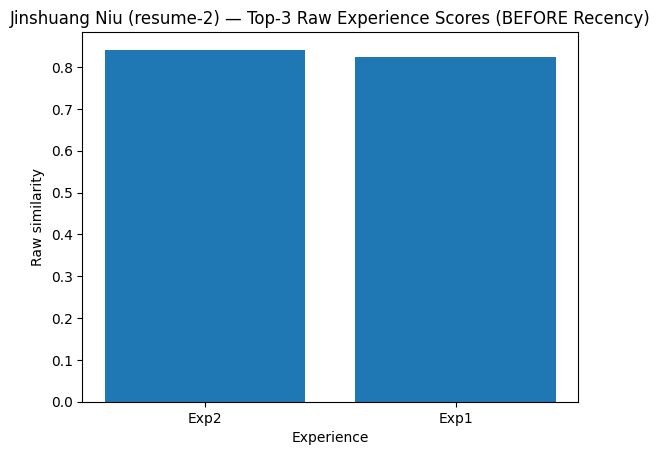

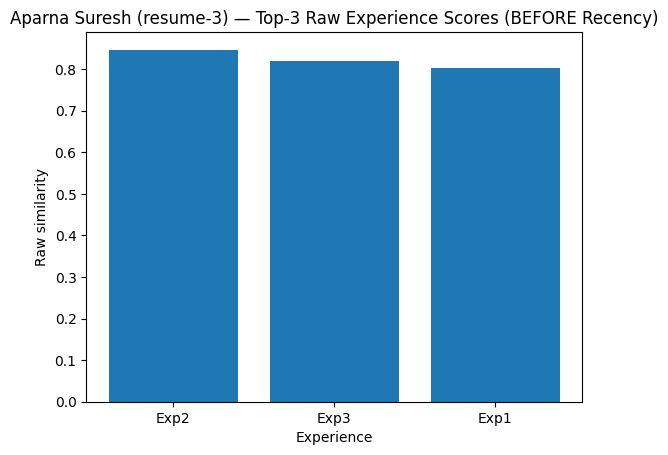

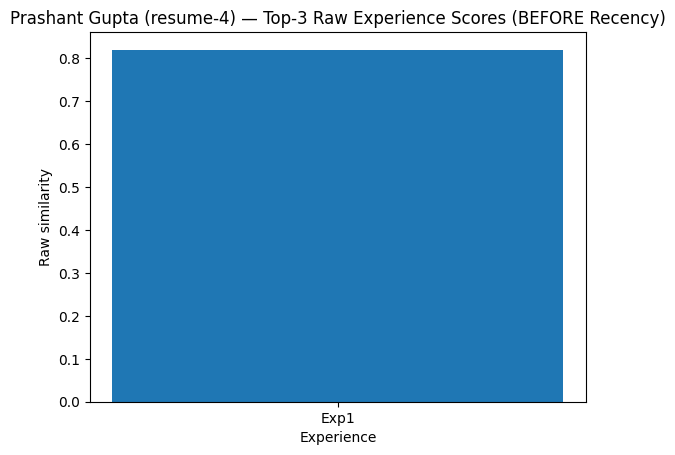

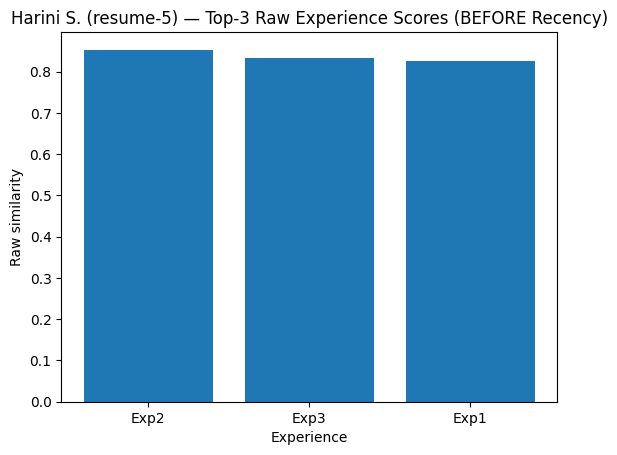

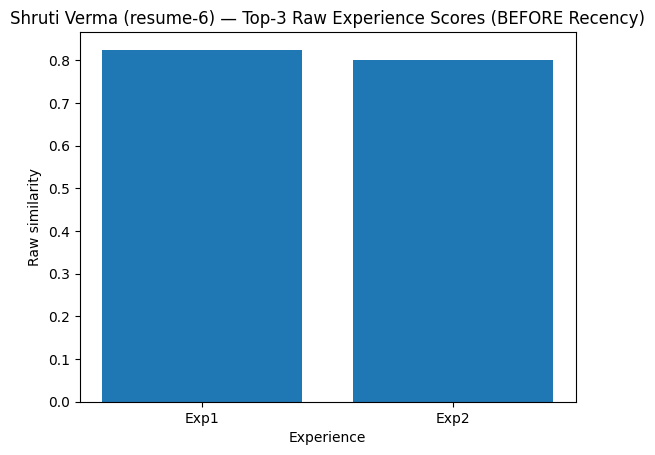

In [72]:
# Select Top ≤3 experiences BEFORE recency

top3_before_per_resume: Dict[str, Dict[str, Any]] = {}

print("Top ≤3 Experiences BEFORE Recency (by raw score)")
for res in resumes_list:
    rid = res.get("resume_id","")
    name = res.get("candidate_name","Unknown")
    items = resume_exp_texts.get(rid, [])
    raw = np.array(raw_scores_per_resume.get(rid, {}).get("raw", []), dtype=float)

    if raw.size == 0 or len(items) == 0:
        top3_before_per_resume[rid] = {"candidate_name": name, "top": [], "avg_top3_raw": 0.0}
        print(f"\n{name} ({rid}): [No experiences]")
        continue

    order = np.argsort(raw)[::-1]
    top_k = order[:3] if raw.size >= 3 else order

    top_items = []
    for idx in top_k:
        it = items[int(idx)]
        top_items.append({
            "exp_index": it["exp_index"],
            "company": it["company"],
            "position": it["position"],
            "duration": it["duration"],
            "raw_score": float(raw[idx]),
        })

    avg_top3 = float(np.mean([t["raw_score"] for t in top_items])) if top_items else 0.0
    top3_before_per_resume[rid] = {"candidate_name": name, "top": top_items, "avg_top3_raw": avg_top3}

    print(f"\n{name} ({rid}) — avg top-3 raw = {avg_top3:.3f}")
    for t in top_items:
        print(f"  Exp {t['exp_index']}: {t['position']} @ {t['company']} | raw={t['raw_score']:.3f} | {t['duration']}")

# --- Visuals across resumes ---
# 1) Bar chart: avg top-3 raw per resume (descending)
pairs = []
for rid, data in top3_before_per_resume.items():
    pairs.append((data["candidate_name"], data["avg_top3_raw"], rid))
pairs.sort(key=lambda x: (-x[1], x[0].lower()))

names = [f"{n} ({rid})" for n,_,rid in pairs]
vals  = [v for _,v,_ in pairs]

plt.figure()
plt.bar(range(len(vals)), vals)
plt.title("Avg Top-3 Raw Similarity per Resume (BEFORE Recency)")
plt.xticks(range(len(vals)), names, rotation=45, ha="right")
plt.ylabel("Avg raw similarity")
plt.tight_layout()
plt.show()

# 2) “Heat” view of top-3 raw scores per resume (if exists)
# (we’ll just plot each resume’s top-3 as a bar chart again for clarity)
for rid, data in top3_before_per_resume.items():
    name = data["candidate_name"]
    top_items = data["top"]
    if not top_items:
        continue
    plt.figure()
    plt.bar([f"Exp{t['exp_index']}" for t in top_items], [t["raw_score"] for t in top_items])
    plt.title(f"{name} ({rid}) — Top-3 Raw Experience Scores (BEFORE Recency)")
    plt.xlabel("Experience")
    plt.ylabel("Raw similarity")
    plt.show()


Adjusted Scores (after Recency) per Experience

Wesley Chen (resume-1)
  Exp 1: raw=0.825 -> adj=0.502 | months_old=47
  Exp 2: raw=0.812 -> adj=0.413 | months_old=59
  Exp 3: raw=0.809 -> adj=0.330 | months_old=71
  Exp 4: raw=0.818 -> adj=0.252 | months_old=83


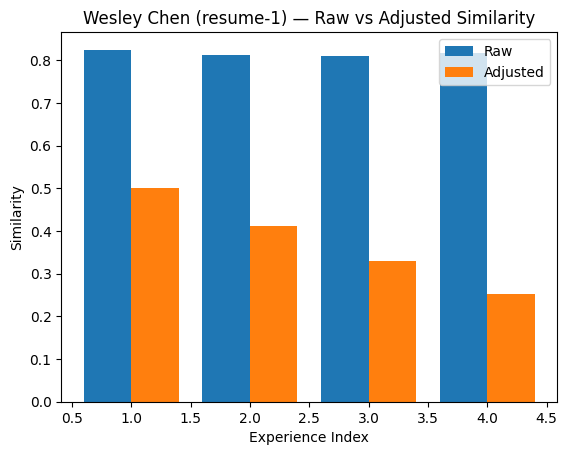

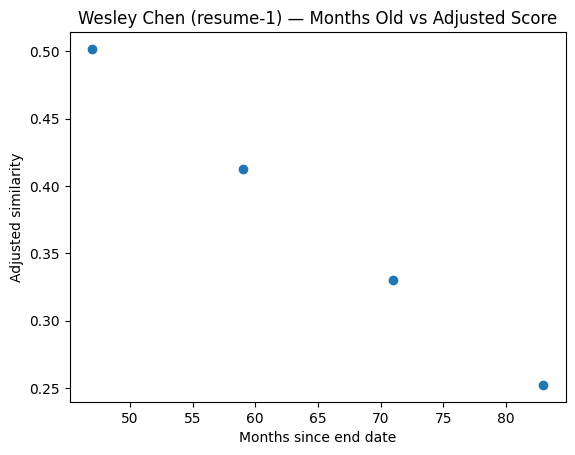


Jinshuang Niu (resume-2)
  Exp 1: raw=0.824 -> adj=0.824 | months_old=0
  Exp 2: raw=0.841 -> adj=0.589 | months_old=36


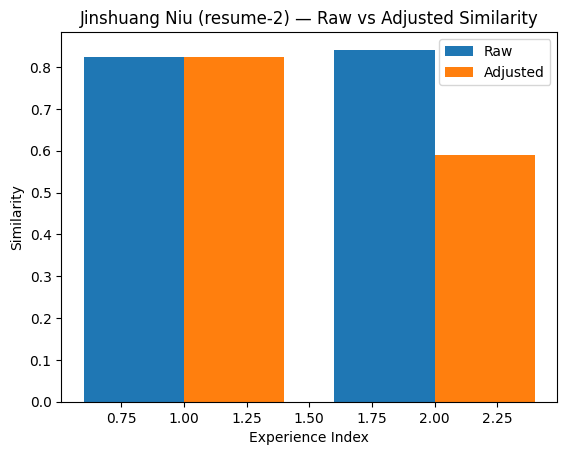

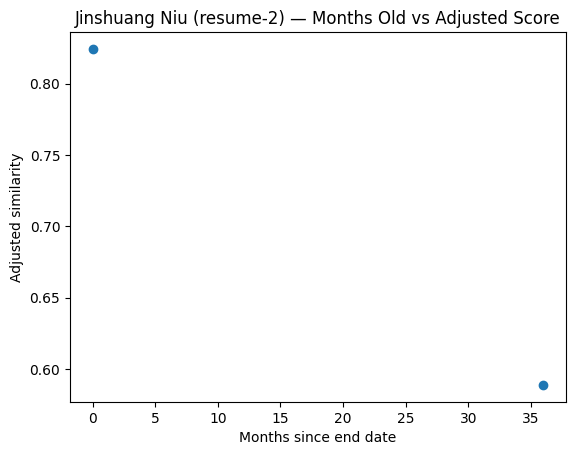


Aparna Suresh (resume-3)
  Exp 1: raw=0.802 -> adj=0.561 | months_old=36
  Exp 2: raw=0.847 -> adj=0.501 | months_old=49
  Exp 3: raw=0.819 -> adj=0.321 | months_old=73


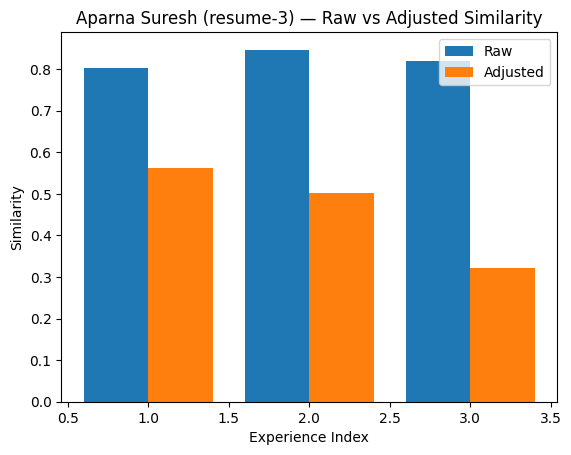

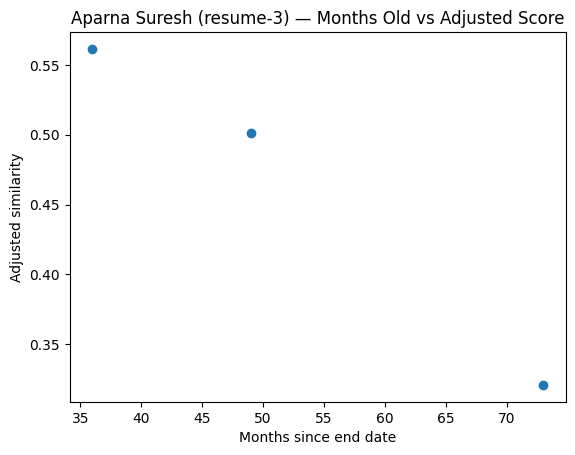


Prashant Gupta (resume-4)
  Exp 1: raw=0.820 -> adj=0.649 | months_old=25


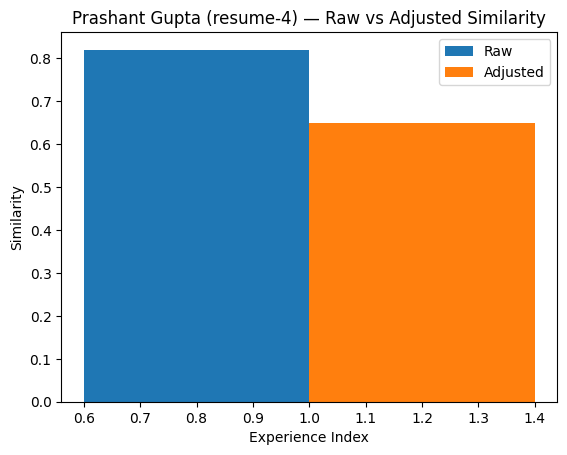

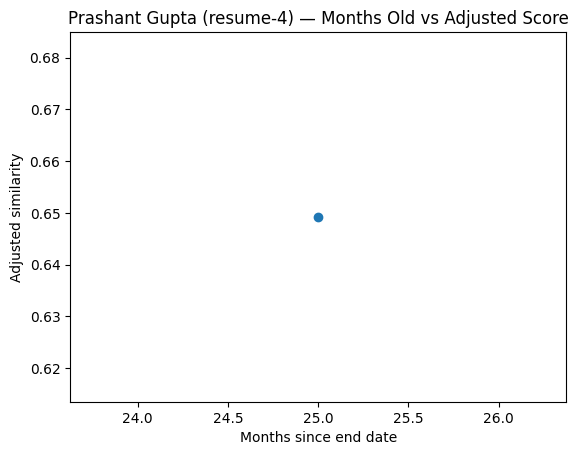


Harini S. (resume-5)
  Exp 1: raw=0.826 -> adj=0.826 | months_old=0
  Exp 2: raw=0.853 -> adj=0.768 | months_old=12
  Exp 3: raw=0.834 -> adj=0.730 | months_old=15


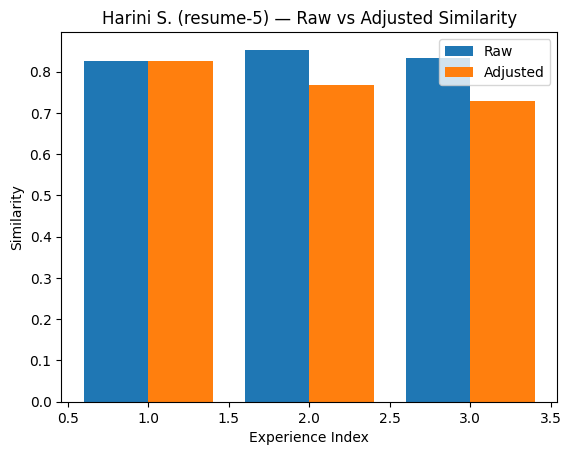

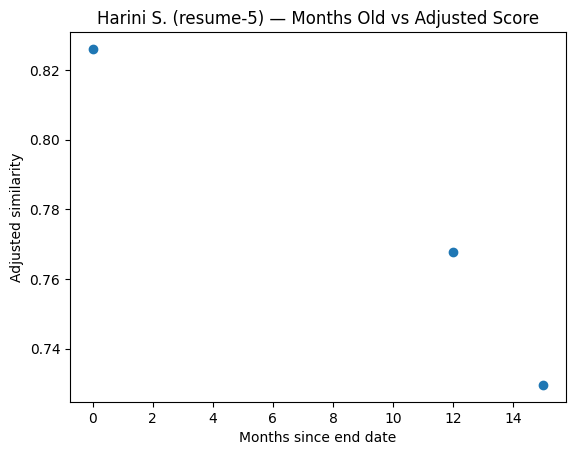


Shruti Verma (resume-6)
  Exp 1: raw=0.825 -> adj=0.660 | months_old=24
  Exp 2: raw=0.800 -> adj=0.620 | months_old=27


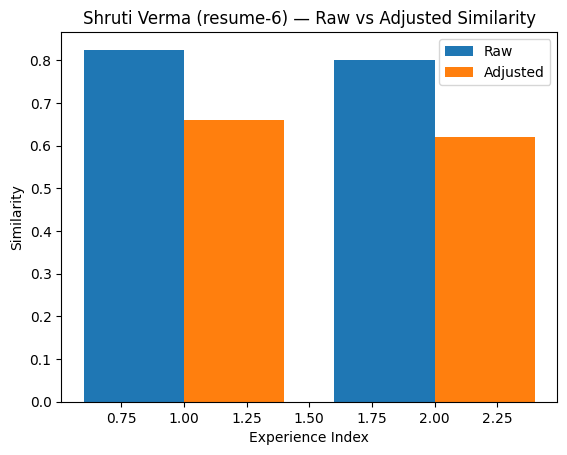

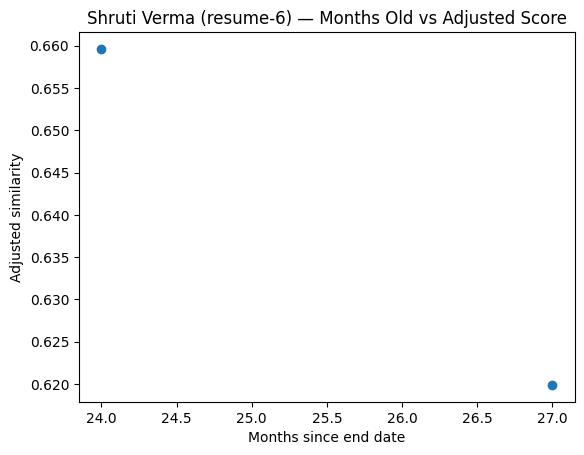

In [73]:
# Recency discount & adjusted scores

from datetime import datetime, timezone

MONTHS = {
    'jan':1,'january':1,'feb':2,'february':2,'mar':3,'march':3,'apr':4,'april':4,
    'may':5,'jun':6,'june':6,'jul':7,'july':7,'aug':8,'august':8,'sep':9,'sept':9,'september':9,
    'oct':10,'october':10,'nov':11,'november':11,'dec':12,'december':12
}

def _to_utc(dt):
    if dt.tzinfo is None:
        return dt.replace(tzinfo=timezone.utc)
    return dt.astimezone(timezone.utc)

def parse_end_date(duration_text: str):
    if not duration_text:
        return datetime.now(timezone.utc)
    t = duration_text.lower()
    if "present" in t:
        return datetime.now(timezone.utc)
    m = re.search(r"[–\-]\s*([a-zA-Z]{3,9})\s+(\d{4})", duration_text)
    if m:
        mon = MONTHS.get(m.group(1).lower(), None)
        year = int(m.group(2))
        if mon:
            return datetime(year, mon, 28, tzinfo=timezone.utc)
    candidates = re.findall(r"([a-zA-Z]{3,9})\s+(\d{4})", duration_text)
    if candidates:
        mon = MONTHS.get(candidates[-1][0].lower(), 12)
        year = int(candidates[-1][1])
        return datetime(year, mon, 28, tzinfo=timezone.utc)
    return datetime.now(timezone.utc)

def months_between(a, b):
    a = _to_utc(a); b = _to_utc(b)
    if a < b: a, b = b, a
    return (a.year - b.year) * 12 + (a.month - b.month)

def recency_factor(end_date, today=None):
    today = _to_utc(today or datetime.now(timezone.utc))
    end_date = _to_utc(end_date)
    m_old = months_between(today, end_date)
    years_old = m_old / 12.0
    if years_old <= 0.5:  # ≤ 6 months old
        return 1.0, m_old
    factor = max(0.0, 1.0 - (years_old / 10.0))
    return factor, m_old

results_after_recency: Dict[str, Dict[str, Any]] = {}

print("Adjusted Scores (after Recency) per Experience")
for res in resumes_list:
    rid = res.get("resume_id","")
    name = res.get("candidate_name","Unknown")
    items = resume_exp_texts.get(rid, [])
    raw = np.array(raw_scores_per_resume.get(rid, {}).get("raw", []), dtype=float)

    if raw.size == 0 or len(items) == 0:
        results_after_recency[rid] = {"candidate_name": name, "adj_scores": [], "months_old": [], "factors": []}
        print(f"\n{name} ({rid}): [No experiences]")
        continue

    factors, mos, adjs = [], [], []
    for i, it in enumerate(items):
        f, m = recency_factor(parse_end_date(it["duration"]))
        factors.append(f); mos.append(m)
        adjs.append(max(0.0, float(raw[i]) * f))

    results_after_recency[rid] = {
        "candidate_name": name,
        "adj_scores": adjs,
        "months_old": mos,
        "factors": factors
    }

    print(f"\n{name} ({rid})")
    for i, (s_raw, s_adj, m) in enumerate(zip(raw, adjs, mos), 1):
        print(f"  Exp {i}: raw={s_raw:.3f} -> adj={s_adj:.3f} | months_old={m}")

    # Visuals per resume 
    # 1) Side-by-side bar (raw vs adjusted) by exp index
    idxs = np.arange(1, len(raw)+1)
    plt.figure()
    plt.bar(idxs - 0.2, raw, width=0.4)
    plt.bar(idxs + 0.2, adjs, width=0.4)
    plt.title(f"{name} ({rid}) — Raw vs Adjusted Similarity")
    plt.xlabel("Experience Index")
    plt.ylabel("Similarity")
    plt.legend(["Raw", "Adjusted"])
    plt.show()

    # 2) Scatter: months_old vs adjusted
    plt.figure()
    plt.scatter(mos, adjs)
    plt.title(f"{name} ({rid}) — Months Old vs Adjusted Score")
    plt.xlabel("Months since end date")
    plt.ylabel("Adjusted similarity")
    plt.show()


Leaderboard BEFORE Recency (Avg Top-3 Raw)
Harini S. (resume-5) : 0.838
Jinshuang Niu (resume-2) : 0.833
Aparna Suresh (resume-3) : 0.823
Prashant Gupta (resume-4) : 0.820
Wesley Chen (resume-1) : 0.818
Shruti Verma (resume-6) : 0.812

Leaderboard AFTER Recency (Avg Top-3 Adjusted)
Harini S. (resume-5) : 0.775
Jinshuang Niu (resume-2) : 0.707
Prashant Gupta (resume-4) : 0.649
Shruti Verma (resume-6) : 0.640
Aparna Suresh (resume-3) : 0.461
Wesley Chen (resume-1) : 0.415


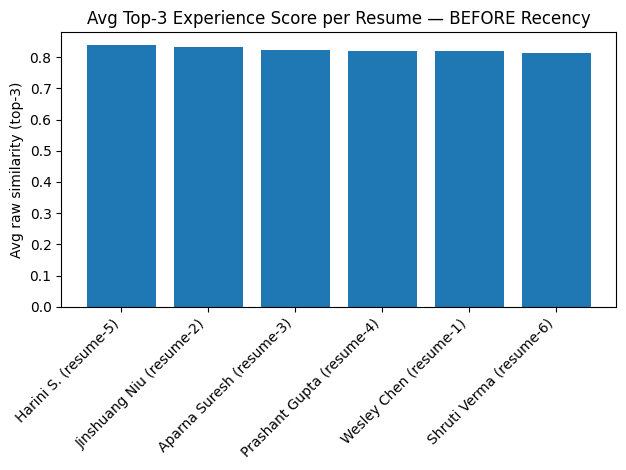

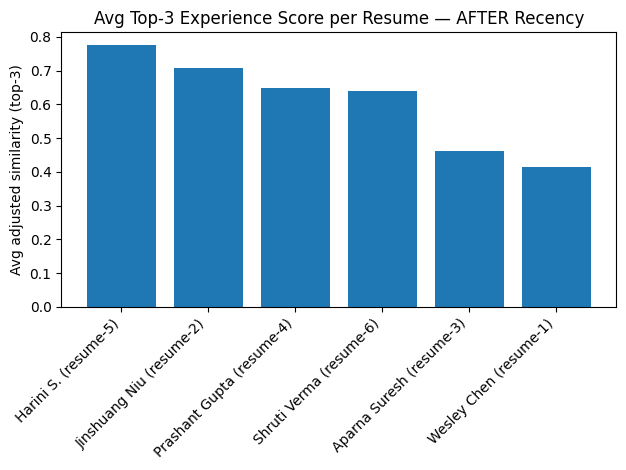

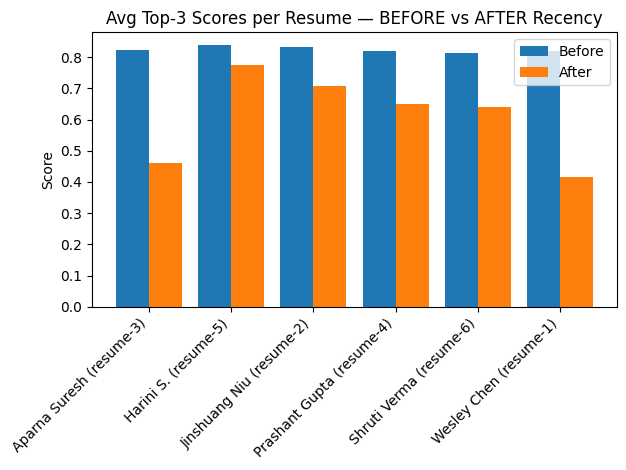

In [74]:
# Top-3 AFTER recency, per-resume averages, leaderboards

top3_after_per_resume: Dict[str, Dict[str, Any]] = {}
leader_before = []  # avg top-3 raw
leader_after  = []  # avg top-3 adjusted

for res in resumes_list:
    rid = res.get("resume_id","")
    name = res.get("candidate_name","Unknown")
    items = resume_exp_texts.get(rid, [])

    raw = np.array(raw_scores_per_resume.get(rid, {}).get("raw", []), dtype=float)
    adjs = np.array(results_after_recency.get(rid, {}).get("adj_scores", []), dtype=float)

    # BEFORE recency
    if raw.size:
        order_raw = np.argsort(raw)[::-1]
        top_raw = order_raw[:3] if raw.size >= 3 else order_raw
        avg_raw = float(np.mean(raw[top_raw])) if top_raw.size else 0.0
    else:
        top_raw = np.array([], dtype=int); avg_raw = 0.0

    # AFTER recency
    if adjs.size:
        order_adj = np.argsort(adjs)[::-1]
        top_adj = order_adj[:3] if adjs.size >= 3 else order_adj
        avg_adj = float(np.mean(adjs[top_adj])) if top_adj.size else 0.0
    else:
        top_adj = np.array([], dtype=int); avg_adj = 0.0

    # Save top-3 AFTER details
    top_items_after = []
    for idx in top_adj:
        it = items[int(idx)]
        top_items_after.append({
            "exp_index": it["exp_index"],
            "company": it["company"],
            "position": it["position"],
            "duration": it["duration"],
            "adjusted_score": float(adjs[idx]),
        })

    top3_after_per_resume[rid] = {
        "candidate_name": name,
        "top_after": top_items_after,
        "avg_top3_adjusted": avg_adj
    }

    leader_before.append((name, rid, avg_raw))
    leader_after.append((name, rid, avg_adj))

# Sort leaderboards
leader_before.sort(key=lambda x: (-x[2], x[0].lower()))
leader_after.sort(key=lambda x: (-x[2], x[0].lower()))

print("Leaderboard BEFORE Recency (Avg Top-3 Raw)")
for name, rid, s in leader_before:
    print(f"{name} ({rid}) : {s:.3f}")

print("\nLeaderboard AFTER Recency (Avg Top-3 Adjusted)")
for name, rid, s in leader_after:
    print(f"{name} ({rid}) : {s:.3f}")

# Visuals
# 1) Bar: BEFORE Recency
names_b = [f"{n} ({rid})" for n,rid,_ in leader_before]
vals_b  = [s for _,_,s in leader_before]
plt.figure()
plt.bar(range(len(vals_b)), vals_b)
plt.title("Avg Top-3 Experience Score per Resume — BEFORE Recency")
plt.xticks(range(len(vals_b)), names_b, rotation=45, ha="right")
plt.ylabel("Avg raw similarity (top-3)")
plt.tight_layout()
plt.show()

# 2) Bar: AFTER Recency
names_a = [f"{n} ({rid})" for n,rid,_ in leader_after]
vals_a  = [s for _,_,s in leader_after]
plt.figure()
plt.bar(range(len(vals_a)), vals_a)
plt.title("Avg Top-3 Experience Score per Resume — AFTER Recency")
plt.xticks(range(len(vals_a)), names_a, rotation=45, ha="right")
plt.ylabel("Avg adjusted similarity (top-3)")
plt.tight_layout()
plt.show()

# 3) Delta view: BEFORE vs AFTER (per resume)
all_names = sorted({*names_b, *names_a})
# Map for quick lookup
map_b = {f"{n} ({rid})": s for n, rid, s in leader_before}
map_a = {f"{n} ({rid})": s for n, rid, s in leader_after}
xs = np.arange(len(all_names))
before_vals = [map_b.get(n, 0.0) for n in all_names]
after_vals  = [map_a.get(n, 0.0) for n in all_names]

plt.figure()
plt.bar(xs - 0.2, before_vals, width=0.4)
plt.bar(xs + 0.2, after_vals, width=0.4)
plt.title("Avg Top-3 Scores per Resume — BEFORE vs AFTER Recency")
plt.xticks(xs, all_names, rotation=45, ha="right")
plt.ylabel("Score")
plt.legend(["Before", "After"])
plt.tight_layout()
plt.show()


In [76]:
# Update results_dict with experience_score (AFTER recency) 

try:
    _ = results_dict
    for name, rid, s in leader_after:
        if rid in results_dict:
            results_dict[rid]["experience_score"] = s
            results_dict[rid]["candidate_name"] = name
    print("Updated results_dict['experience_score'] (AFTER recency):")
    for rid, rec in results_dict.items():
        print(f"{rid}: {rec.get('candidate_name','?')} -> experience_score={rec.get('experience_score')}")
except NameError:
    print("results_dict not defined in this session; skipping update.")


Updated results_dict['experience_score'] (AFTER recency):
resume-1: Wesley Chen -> experience_score=0.4149533786707454
resume-2: Jinshuang Niu -> experience_score=0.7065977096557616
resume-3: Aparna Suresh -> experience_score=0.4611182843645414
resume-4: Prashant Gupta -> experience_score=0.6492314487695694
resume-5: Harini S. -> experience_score=0.7745165477196375
resume-6: Shruti Verma -> experience_score=0.6397577747702599


In [77]:
# Print & Update results_dict with experience_score

# 1) Print current results_dict
print("Current results_dict")
try:
    for rid, rec in results_dict.items():
        print(f"{rid}: {rec}")
except NameError:
    raise RuntimeError("results_dict is not defined in this notebook/session.")

# 2) Update with experience_score from top3_after_per_resume
for rid, data in top3_after_per_resume.items():
    exp_score = data.get("avg_top3_adjusted", 0.0)
    if rid in results_dict:
        results_dict[rid]["experience_score"] = exp_score
        # Optional: ensure candidate_name is synced too
        results_dict[rid]["candidate_name"] = data.get("candidate_name", results_dict[rid].get("candidate_name"))

# 3) Print updated results_dict
print("\nUpdated results_dict (with experience_score)")
for rid, rec in results_dict.items():
    print(f"{rid}: {rec}")


Current results_dict
resume-1: {'job_id': 'job_2025_001', 'resume_id': 'resume-1', 'run_id': '8dcd1e', 'education_score': 0.872567668557167, 'skills_score': None, 'project_score': None, 'experience_score': 0.4149533786707454, 'composite': None, 'rank': None, 'candidate_name': 'Wesley Chen'}
resume-2: {'job_id': 'job_2025_001', 'resume_id': 'resume-2', 'run_id': '8dcd1e', 'education_score': 0.8809771835803986, 'skills_score': None, 'project_score': None, 'experience_score': 0.7065977096557616, 'composite': None, 'rank': None, 'candidate_name': 'Jinshuang Niu'}
resume-3: {'job_id': 'job_2025_001', 'resume_id': 'resume-3', 'run_id': '8dcd1e', 'education_score': 0.884216383099556, 'skills_score': None, 'project_score': None, 'experience_score': 0.4611182843645414, 'composite': None, 'rank': None, 'candidate_name': 'Aparna Suresh'}
resume-4: {'job_id': 'job_2025_001', 'resume_id': 'resume-4', 'run_id': '8dcd1e', 'education_score': 0.8641859591007233, 'skills_score': None, 'project_score': N

# Calculate Projects Sematic score

Job Responsibilities (bullets)
1. Design and execute experiments using Python, Pandas, Weights & Biases, MySQL, and LLMs.
2. Train, test, and deploy state-of-the-art machine learning models in production.
3. Work with staff machine learning engineers to find technical solutions for complex business problems.
4. Communicate clearly across mediums and functions (experiment write-ups, code reviews, company-wide presentations).

Concatenated Job Responsibilities (single text)
Design and execute experiments using Python, Pandas, Weights & Biases, MySQL, and LLMs. Train, test, and deploy state-of-the-art machine learning models in production. Work with staff machine learning engineers to find technical solutions for complex business problems. Communicate clearly across mediums and functions (experiment write-ups, code reviews, company-wide presentations).

Candidate Projects (per project concatenated)

Candidate: Wesley Chen (resume_id=resume-1)
  [No projects]

Candidate: Jinshuang Niu (res

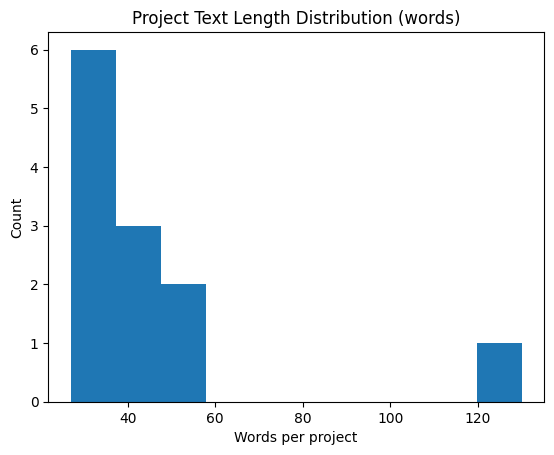

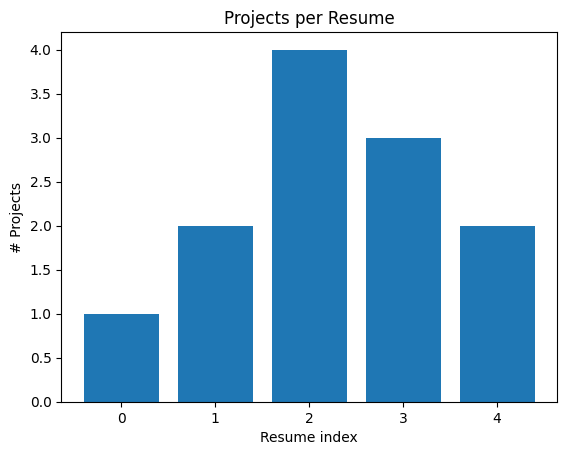

In [78]:
# Build & inspect project texts (with skills)

import re
from typing import List, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

def normalize_text(x: str) -> str:
    return re.sub(r"\s+", " ", (x or "").strip())

def concat_sentences(parts: List[str]) -> str:
    parts = [normalize_text(p) for p in (parts or []) if normalize_text(p)]
    return " ".join(parts)

# 1) Job responsibilities (same as experience pipeline)
job_responsibilities_list = job_dict.get("responsibilities", []) or []
job_responsibilities_text = concat_sentences(job_responsibilities_list)

print("Job Responsibilities (bullets)")
for i, r in enumerate(job_responsibilities_list, 1):
    print(f"{i}. {r}")

print("\nConcatenated Job Responsibilities (single text)")
print(job_responsibilities_text)

# 2) Per-resume, per-project text (name + description + skills)
resume_proj_texts: Dict[str, List[Dict[str, Any]]] = {}
proj_lengths = []  # quick stats per project

print("\nCandidate Projects (per project concatenated)")
for res in resumes_list:
    rid = res.get("resume_id", "")
    name = res.get("candidate_name", "Unknown")
    projects = res.get("projects", []) or []
    out = []

    print(f"\nCandidate: {name} (resume_id={rid})")
    if not projects:
        print("  [No projects]")
        resume_proj_texts[rid] = []
        continue

    for i, p in enumerate(projects, 1):
        pname = normalize_text(p.get("project_name", ""))
        desc_lines = p.get("project_description", []) or []
        desc_text = concat_sentences(desc_lines)
        skills = [normalize_text(s) for s in (p.get("skills") or []) if normalize_text(s)]

        # Skip empty projects
        if not (pname or desc_text or skills):
            continue

        # Build the project text: name + description + skills suffix
        comp = []
        if pname:
            comp.append(pname)
        if desc_text:
            comp.append(desc_text)
        if skills:
            comp.append("Skills: " + ", ".join(skills))
        full_text = ". ".join([c for c in comp if c])

        words = len(full_text.split())
        out.append({
            "proj_index": i,
            "project_name": pname,
            "text": full_text,
            "duration": p.get("duration", ""),
        })

        print(f"  Project {i}: {pname or '[no name]'}")
        print(f"    Duration: {p.get('duration','')}")
        print(f"    Words: {words}")
        print(f"    Text: {full_text[:200]}{'...' if len(full_text)>200 else ''}")

        proj_lengths.append((rid, name, i, words))

    resume_proj_texts[rid] = out

# visuals over project sizes
# A) Histogram of project text lengths (words)
if proj_lengths:
    plt.figure()
    plt.hist([x[3] for x in proj_lengths], bins=10)
    plt.title("Project Text Length Distribution (words)")
    plt.xlabel("Words per project")
    plt.ylabel("Count")
    plt.show()

    # B) Projects per resume (count)
    counts = {}
    for rid, _, _, _ in proj_lengths:
        counts[rid] = counts.get(rid, 0) + 1
    plt.figure()
    plt.bar(range(len(counts)), list(counts.values()))
    plt.title("Projects per Resume")
    plt.xlabel("Resume index")
    plt.ylabel("# Projects")
    plt.show()


Raw semantic similarity (Job Responsibilities vs Project)

Wesley Chen (resume-1): [No projects]

Jinshuang Niu (resume-2)
  Task Management & Microservice Architecture Design: raw score = 0.826


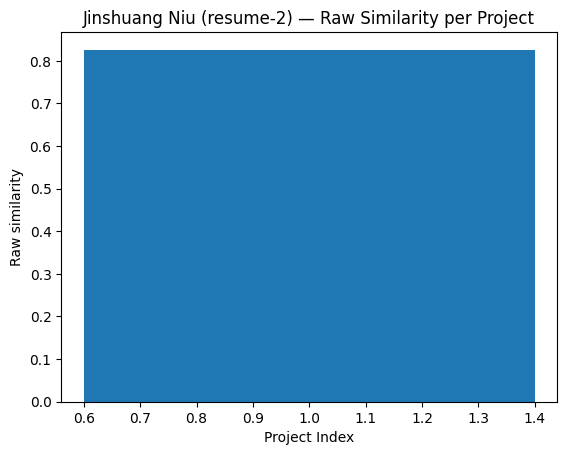

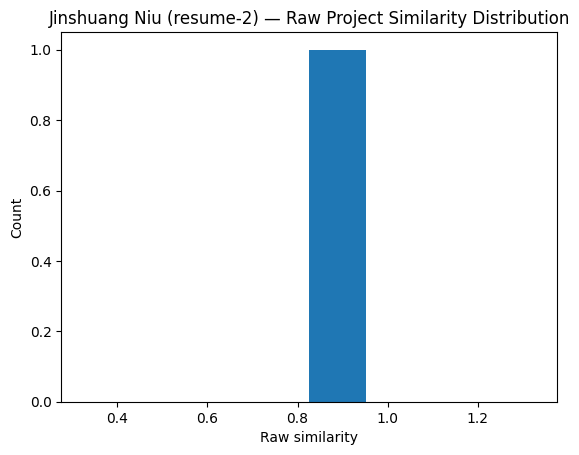


Aparna Suresh (resume-3)
  Distributed Systems – Sharded Key-Value Store: raw score = 0.803
  Operating Systems – XINU, x86, Solaris: raw score = 0.810


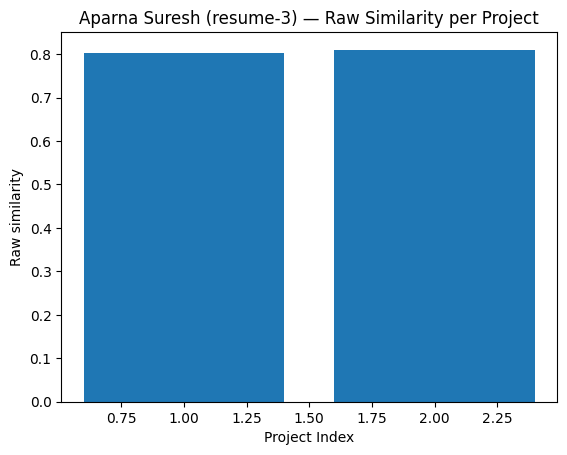

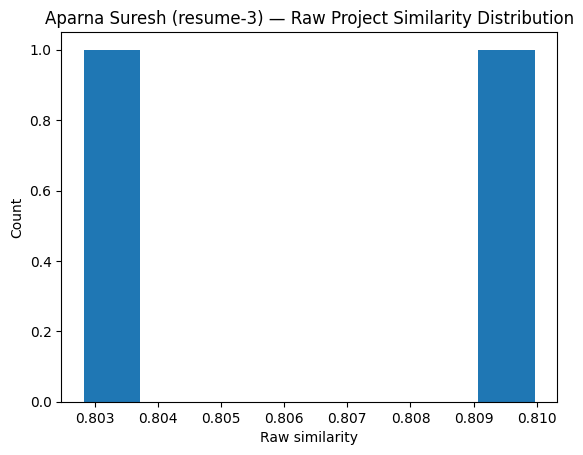


Prashant Gupta (resume-4)
  TalentTrek: AI-Powered Career Companion: raw score = 0.858
  Integrative Machine Learning Applications: raw score = 0.861
  Detection of Defects in Computer Chips and MLOps: raw score = 0.848
  AI Interviewer: raw score = 0.846


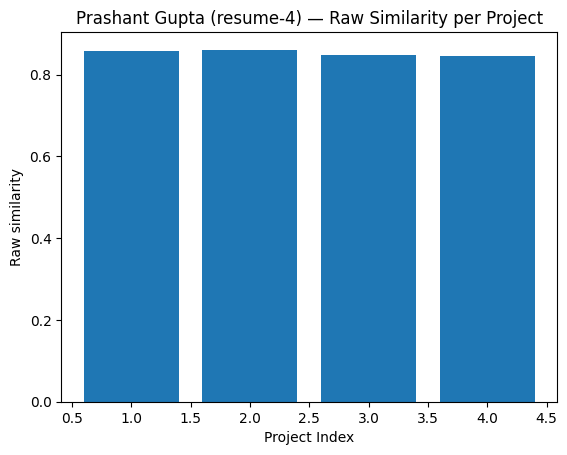

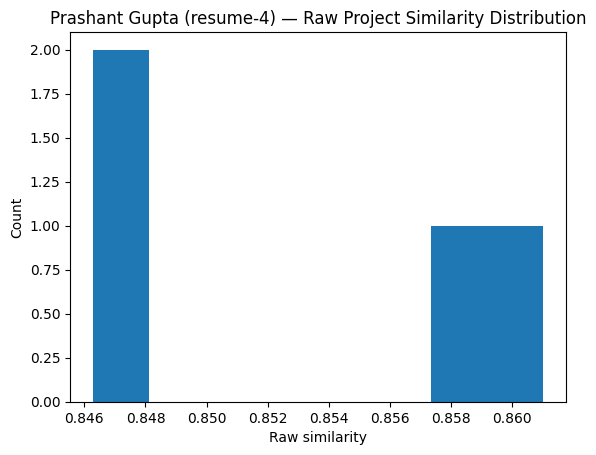


Harini S. (resume-5)
  Semantic Resume Matching System: raw score = 0.820
  Cloud-Native Delta Lake Development: raw score = 0.809
  Toxicity Detection in Multiplayer Game Chats: raw score = 0.830


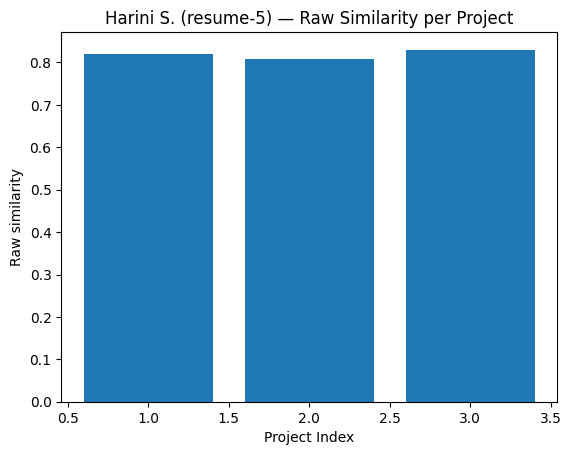

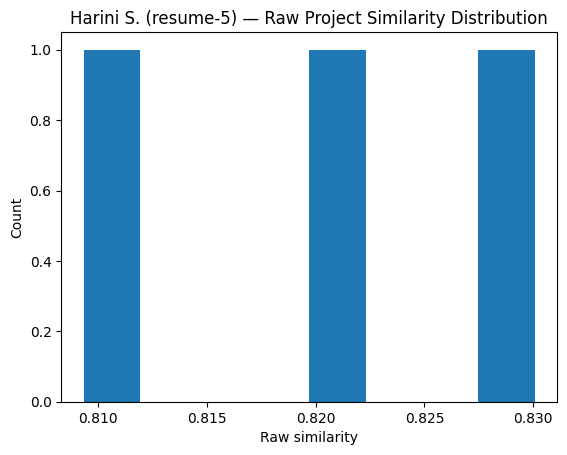


Shruti Verma (resume-6)
  Real-Time Event Processing Platform: raw score = 0.823
  Secure Document Management System: raw score = 0.792


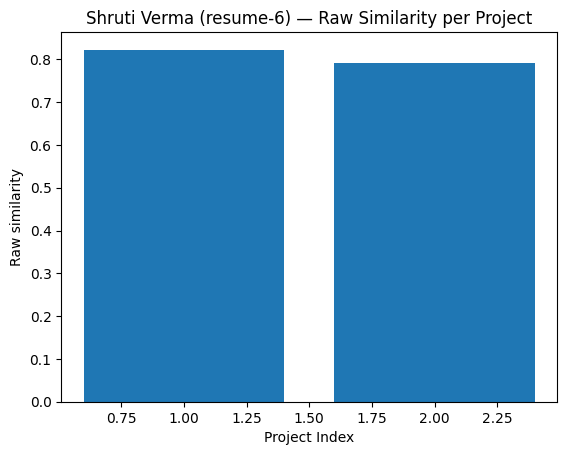

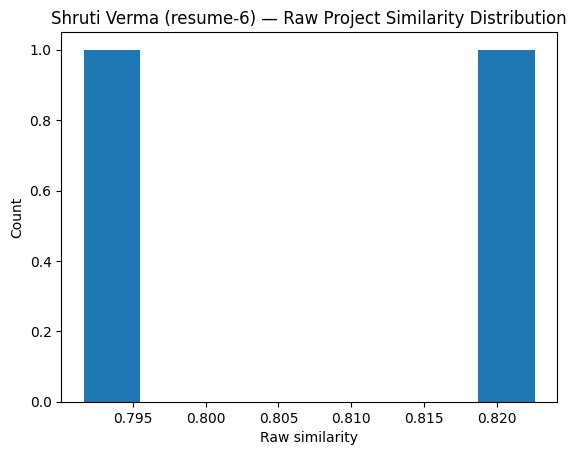

In [79]:
# Embed & compute raw semantic scores (Job vs Each Project)

from sentence_transformers import SentenceTransformer

def encode_batch(model, texts):
    texts = [f"query: {normalize_text(t)}" for t in texts]
    return model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

# Reuse model if loaded else load now
try:
    _ = model
except NameError:
    model = SentenceTransformer("intfloat/e5-base-v2")

job_emb = encode_batch(model, [job_responsibilities_text])[0]

raw_proj_scores_per_resume: Dict[str, Dict[str, Any]] = {}

print("Raw semantic similarity (Job Responsibilities vs Project)")
for res in resumes_list:
    rid = res.get("resume_id","")
    name = res.get("candidate_name","Unknown")
    projs = resume_proj_texts.get(rid, [])
    texts = [it["text"] for it in projs]

    if not texts:
        raw_proj_scores_per_resume[rid] = {"candidate_name": name, "raw": [], "project_names": []}
        print(f"\n{name} ({rid}): [No projects]")
        continue

    proj_embs = encode_batch(model, texts)           
    sims = np.dot(proj_embs, job_emb)                
    raw_proj_scores_per_resume[rid] = {
        "candidate_name": name,
        "raw": sims.tolist(),
        "project_names": [it["project_name"] or f"Project {it['proj_index']}" for it in projs]
    }

    print(f"\n{name} ({rid})")
    for i, s in enumerate(sims, 1):
        pname = projs[i-1]["project_name"] or f"Project {i}"
        print(f"  {pname}: raw score = {float(s):.3f}")

    # Per-resume visuals
    # 1) Bar: raw project scores
    plt.figure()
    plt.bar(range(1, len(sims)+1), sims)
    plt.title(f"{name} ({rid}) — Raw Similarity per Project")
    plt.xlabel("Project Index")
    plt.ylabel("Raw similarity")
    plt.show()

    # 2) Histogram: raw scores
    plt.figure()
    plt.hist(sims, bins=8)
    plt.title(f"{name} ({rid}) — Raw Project Similarity Distribution")
    plt.xlabel("Raw similarity")
    plt.ylabel("Count")
    plt.show()


Top ≤3 Projects per Resume (raw scores) 

Wesley Chen (resume-1) — avg top-3 = 0.000

Jinshuang Niu (resume-2) — avg top-3 = 0.826
  Task Management & Microservice Architecture Design (ExpIdx=1): raw=0.826 | Not listed

Aparna Suresh (resume-3) — avg top-3 = 0.806
  Operating Systems – XINU, x86, Solaris (ExpIdx=2): raw=0.810 | Not listed
  Distributed Systems – Sharded Key-Value Store (ExpIdx=1): raw=0.803 | Not listed

Prashant Gupta (resume-4) — avg top-3 = 0.856
  Integrative Machine Learning Applications (ExpIdx=2): raw=0.861 | Not listed
  TalentTrek: AI-Powered Career Companion (ExpIdx=1): raw=0.858 | Not listed
  Detection of Defects in Computer Chips and MLOps (ExpIdx=3): raw=0.848 | Not listed

Harini S. (resume-5) — avg top-3 = 0.820
  Toxicity Detection in Multiplayer Game Chats (ExpIdx=3): raw=0.830 | Not listed
  Semantic Resume Matching System (ExpIdx=1): raw=0.820 | Not listed
  Cloud-Native Delta Lake Development (ExpIdx=2): raw=0.809 | Not listed

Shruti Verma (resume

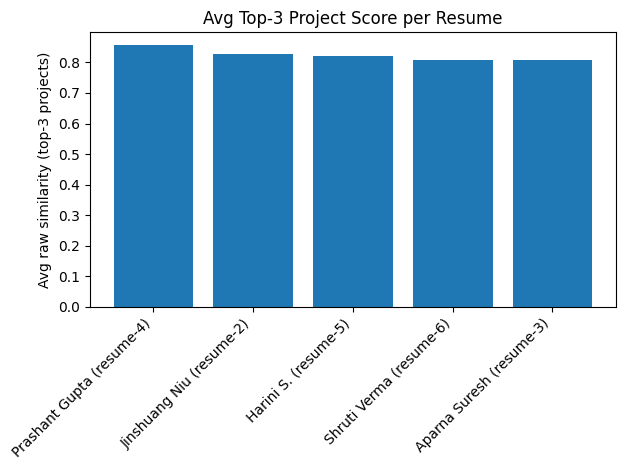

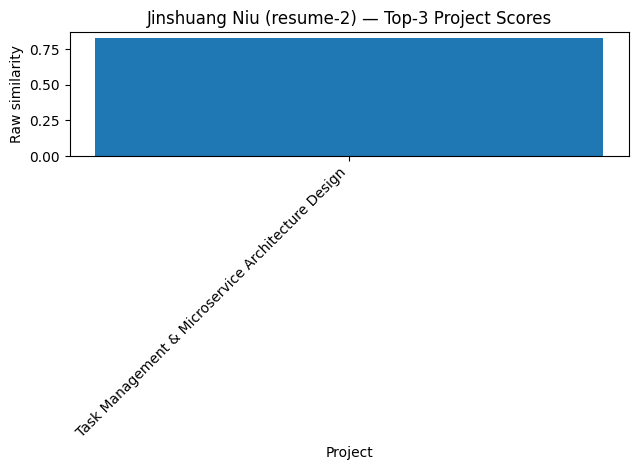

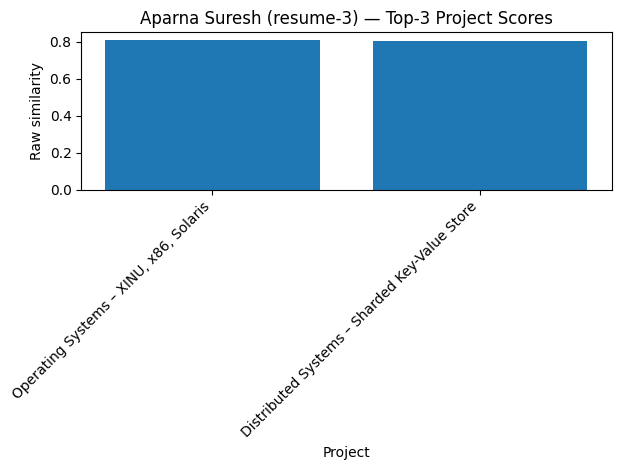

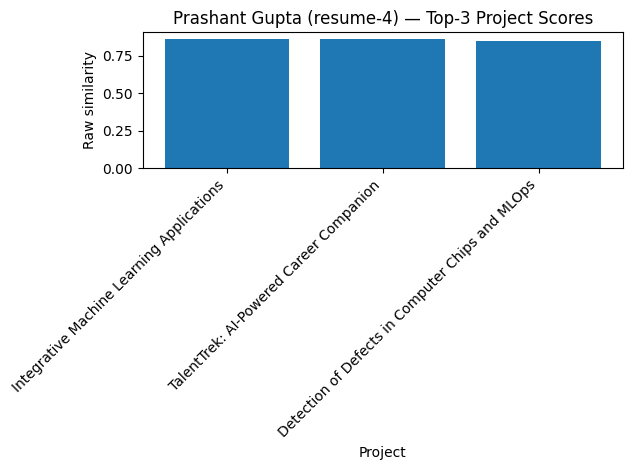

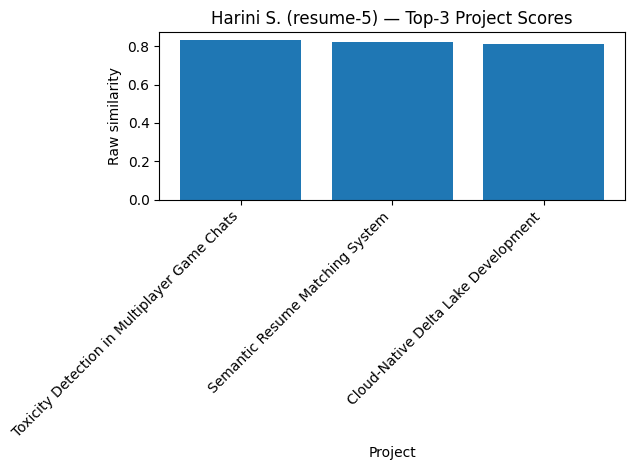

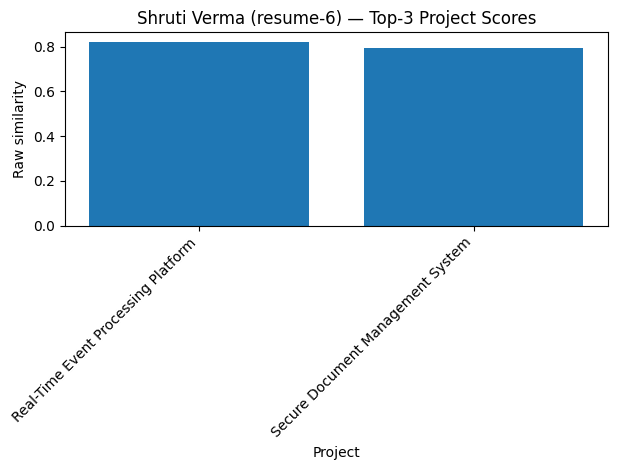

In [80]:
# Select Top ≤3 projects & compute per-resume project_score

top3_projects_per_resume: Dict[str, Dict[str, Any]] = {}
project_leaderboard = []  # (name, rid, avg_top3)

for res in resumes_list:
    rid = res.get("resume_id","")
    name = res.get("candidate_name","Unknown")
    projs = resume_proj_texts.get(rid, [])
    raw = np.array(raw_proj_scores_per_resume.get(rid, {}).get("raw", []), dtype=float)

    if raw.size == 0 or len(projs) == 0:
        top3_projects_per_resume[rid] = {
            "candidate_name": name,
            "top": [],
            "avg_top3_raw": 0.0
        }
        continue

    order = np.argsort(raw)[::-1]
    top_k = order[:3] if raw.size >= 3 else order

    top_items = []
    for idx in top_k:
        it = projs[int(idx)]
        top_items.append({
            "proj_index": it["proj_index"],
            "project_name": it["project_name"] or f"Project {it['proj_index']}",
            "duration": it.get("duration",""),
            "raw_score": float(raw[idx])
        })

    avg_top3 = float(np.mean([t["raw_score"] for t in top_items])) if top_items else 0.0
    top3_projects_per_resume[rid] = {
        "candidate_name": name,
        "top": top_items,
        "avg_top3_raw": avg_top3
    }
    project_leaderboard.append((name, rid, avg_top3))

# Sort leaderboard
project_leaderboard.sort(key=lambda x: (-x[2], x[0].lower()))

# Print readable summary
print("Top ≤3 Projects per Resume (raw scores) ")
for rid, data in top3_projects_per_resume.items():
    name = data["candidate_name"]
    top_items = data["top"]
    print(f"\n{name} ({rid}) — avg top-3 = {data['avg_top3_raw']:.3f}")
    for t in top_items:
        print(f"  {t['project_name']} (ExpIdx={t['proj_index']}): raw={t['raw_score']:.3f} | {t['duration']}")

print("\nProject Score Leaderboard (Avg Top-3 Raw)")
for name, rid, s in project_leaderboard:
    print(f"{name} ({rid}) : {s:.3f}")

# Visuals across resumes
# 1) Bar: Avg top-3 project score per resume (descending)
if project_leaderboard:
    names = [f"{n} ({rid})" for n, rid, _ in project_leaderboard]
    vals  = [s for _, _, s in project_leaderboard]
    plt.figure()
    plt.bar(range(len(vals)), vals)
    plt.title("Avg Top-3 Project Score per Resume")
    plt.xticks(range(len(vals)), names, rotation=45, ha="right")
    plt.ylabel("Avg raw similarity (top-3 projects)")
    plt.tight_layout()
    plt.show()

# 2) For each resume: Top-3 project scores bar
for rid, data in top3_projects_per_resume.items():
    name = data["candidate_name"]
    top_items = data["top"]
    if not top_items:
        continue
    plt.figure()
    plt.bar([t["project_name"] for t in top_items], [t["raw_score"] for t in top_items])
    plt.title(f"{name} ({rid}) — Top-3 Project Scores")
    plt.xlabel("Project")
    plt.ylabel("Raw similarity")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Top ≤3 Projects per Resume (raw scores)

Wesley Chen (resume-1) — avg top-3 = 0.000

Jinshuang Niu (resume-2) — avg top-3 = 0.826
  Task Management & Microservice Architecture Design (ExpIdx=1): raw=0.826 | Not listed

Aparna Suresh (resume-3) — avg top-3 = 0.806
  Operating Systems – XINU, x86, Solaris (ExpIdx=2): raw=0.810 | Not listed
  Distributed Systems – Sharded Key-Value Store (ExpIdx=1): raw=0.803 | Not listed

Prashant Gupta (resume-4) — avg top-3 = 0.856
  Integrative Machine Learning Applications (ExpIdx=2): raw=0.861 | Not listed
  TalentTrek: AI-Powered Career Companion (ExpIdx=1): raw=0.858 | Not listed
  Detection of Defects in Computer Chips and MLOps (ExpIdx=3): raw=0.848 | Not listed

Harini S. (resume-5) — avg top-3 = 0.820
  Toxicity Detection in Multiplayer Game Chats (ExpIdx=3): raw=0.830 | Not listed
  Semantic Resume Matching System (ExpIdx=1): raw=0.820 | Not listed
  Cloud-Native Delta Lake Development (ExpIdx=2): raw=0.809 | Not listed

Shruti Verma (resume-

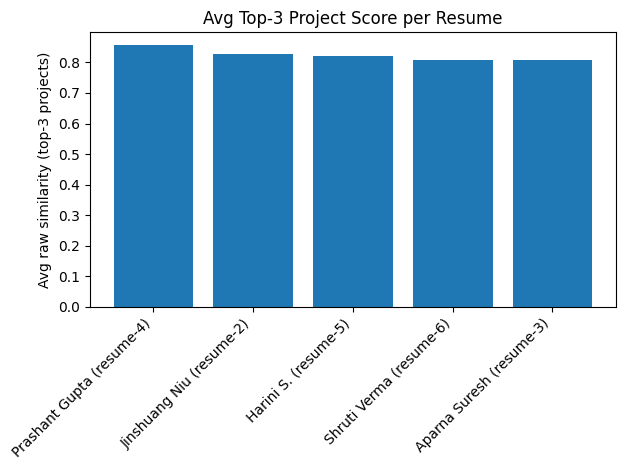

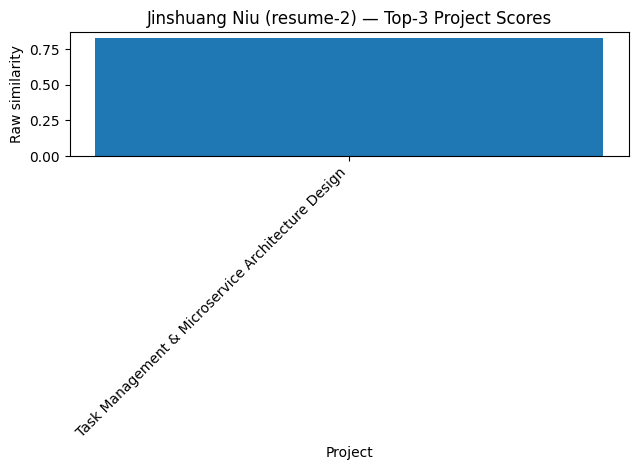

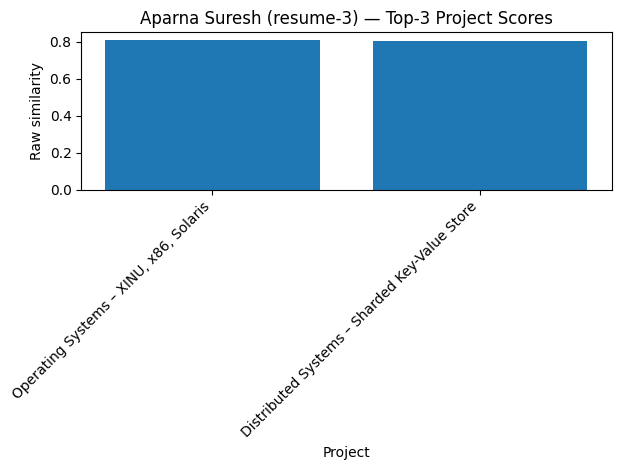

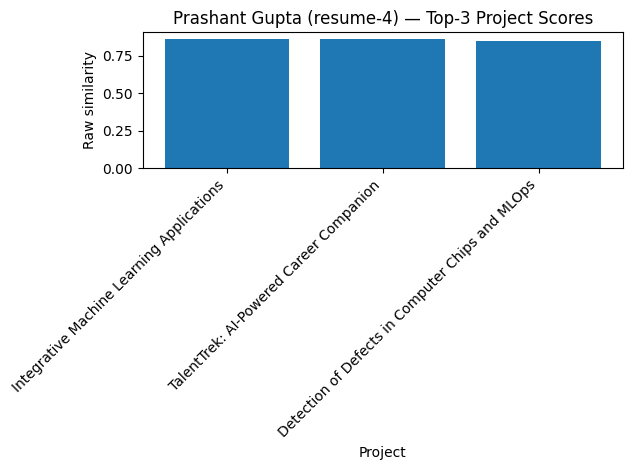

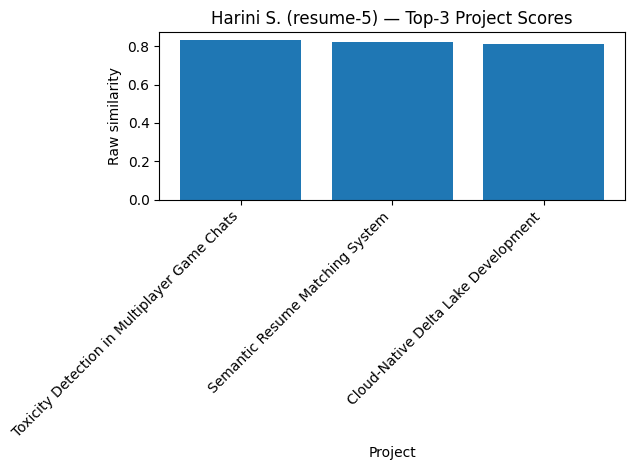

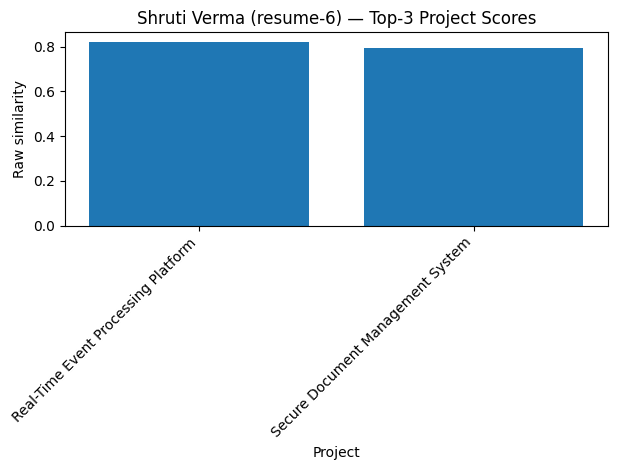

In [83]:
# Select Top ≤3 projects & compute per-resume project_score

top3_projects_per_resume: Dict[str, Dict[str, Any]] = {}
project_leaderboard = []  # (name, rid, avg_top3)

for res in resumes_list:
    rid = res.get("resume_id","")
    name = res.get("candidate_name","Unknown")
    projs = resume_proj_texts.get(rid, [])
    raw = np.array(raw_proj_scores_per_resume.get(rid, {}).get("raw", []), dtype=float)

    if raw.size == 0 or len(projs) == 0:
        top3_projects_per_resume[rid] = {
            "candidate_name": name,
            "top": [],
            "avg_top3_raw": 0.0
        }
        continue

    order = np.argsort(raw)[::-1]
    top_k = order[:3] if raw.size >= 3 else order

    top_items = []
    for idx in top_k:
        it = projs[int(idx)]
        top_items.append({
            "proj_index": it["proj_index"],
            "project_name": it["project_name"] or f"Project {it['proj_index']}",
            "duration": it.get("duration",""),
            "raw_score": float(raw[idx])
        })

    avg_top3 = float(np.mean([t["raw_score"] for t in top_items])) if top_items else 0.0
    top3_projects_per_resume[rid] = {
        "candidate_name": name,
        "top": top_items,
        "avg_top3_raw": avg_top3
    }
    project_leaderboard.append((name, rid, avg_top3))

# Sort leaderboard
project_leaderboard.sort(key=lambda x: (-x[2], x[0].lower()))

# Print readable summary
print("Top ≤3 Projects per Resume (raw scores)")
for rid, data in top3_projects_per_resume.items():
    name = data["candidate_name"]
    top_items = data["top"]
    print(f"\n{name} ({rid}) — avg top-3 = {data['avg_top3_raw']:.3f}")
    for t in top_items:
        print(f"  {t['project_name']} (ExpIdx={t['proj_index']}): raw={t['raw_score']:.3f} | {t['duration']}")

print("\nProject Score Leaderboard (Avg Top-3 Raw)")
for name, rid, s in project_leaderboard:
    print(f"{name} ({rid}) : {s:.3f}")

# Visuals across resumes ---
# 1) Bar: Avg top-3 project score per resume (descending)
if project_leaderboard:
    names = [f"{n} ({rid})" for n, rid, _ in project_leaderboard]
    vals  = [s for _, _, s in project_leaderboard]
    plt.figure()
    plt.bar(range(len(vals)), vals)
    plt.title("Avg Top-3 Project Score per Resume")
    plt.xticks(range(len(vals)), names, rotation=45, ha="right")
    plt.ylabel("Avg raw similarity (top-3 projects)")
    plt.tight_layout()
    plt.show()

# 2) For each resume: Top-3 project scores bar
for rid, data in top3_projects_per_resume.items():
    name = data["candidate_name"]
    top_items = data["top"]
    if not top_items:
        continue
    plt.figure()
    plt.bar([t["project_name"] for t in top_items], [t["raw_score"] for t in top_items])
    plt.title(f"{name} ({rid}) — Top-3 Project Scores")
    plt.xlabel("Project")
    plt.ylabel("Raw similarity")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [84]:
#Update results_dict with project_score
import json

# Use avg top-3 raw as the project_score
try:
    _ = results_dict
except NameError:
    raise RuntimeError("results_dict is not defined in this session.")

for rid, data in top3_projects_per_resume.items():
    score = data.get("avg_top3_raw", 0.0)
    if rid in results_dict:
        results_dict[rid]["project_score"] = score
        # store candidate_name for convenience if not present
        results_dict[rid]["candidate_name"] = data.get("candidate_name", results_dict[rid].get("candidate_name"))

# print full updated results_dict
print("=== Updated results_dict (full JSON with project_score) ===")
print(json.dumps(results_dict, indent=2))



=== Updated results_dict (full JSON with project_score) ===
{
  "resume-1": {
    "job_id": "job_2025_001",
    "resume_id": "resume-1",
    "run_id": "8dcd1e",
    "education_score": 0.872567668557167,
    "skills_score": null,
    "project_score": 0.0,
    "experience_score": 0.4149533786707454,
    "composite": null,
    "rank": null,
    "candidate_name": "Wesley Chen"
  },
  "resume-2": {
    "job_id": "job_2025_001",
    "resume_id": "resume-2",
    "run_id": "8dcd1e",
    "education_score": 0.8809771835803986,
    "skills_score": null,
    "project_score": 0.8260457515716553,
    "experience_score": 0.7065977096557616,
    "composite": null,
    "rank": null,
    "candidate_name": "Jinshuang Niu"
  },
  "resume-3": {
    "job_id": "job_2025_001",
    "resume_id": "resume-3",
    "run_id": "8dcd1e",
    "education_score": 0.884216383099556,
    "skills_score": null,
    "project_score": 0.8063973486423492,
    "experience_score": 0.4611182843645414,
    "composite": null,
    "ra

# Skills Skills Semantic Score

In [87]:
#Semantic Skills Matching (job skills vs candidate exp+project skills)
import json
import re
from typing import List, Dict, Any
import numpy as np

# Helpers
SIM_THRESHOLD = 0.70  # semantic match threshold

def norm_skill(s: str) -> str:
    """
    Normalize a skill string: lowercase, trim, collapse spaces, strip punctuation.
    Also expand common symbols (& -> 'and').
    """
    s = (s or "").lower().strip()
    s = s.replace("&", " and ")
    s = re.sub(r"[\(\)\[\]\{\}:/\\|]", " ", s)  # separators to spaces
    s = re.sub(r"[^a-z0-9\.\+\#\-\s]", "", s)   # keep alnum and . + # - space
    s = re.sub(r"\s+", " ", s).strip()
    return s

def encode_batch_e5(model, texts: List[str]) -> np.ndarray:
    texts = [f"query: {t.strip()}" if t else "query: " for t in texts]
    return model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)


# Collect job skills
job_skills_raw = job_dict.get("skills", []) or []
job_skills = [norm_skill(s) for s in job_skills_raw if norm_skill(s)]
job_skills = list(dict.fromkeys(job_skills))  # de-duplicate, preserve order

print("Job Skills (normalized)")
for s in job_skills:
    print("-", s)

if not job_skills:
    raise ValueError("No job skills found in job_dict['skills']; cannot compute skills_score.")


# Collect candidate skills (ONLY from experiences and projects)
resume_skills_map: Dict[str, Dict[str, Any]] = {}  # rid -> { 'name':..., 'skills': set([...]) }

for r in resumes_list:
    rid = r.get("resume_id", "")
    name = r.get("candidate_name", "Unknown")
    cand_skills_set = set()

    # Experience skills
    for exp in r.get("experience", []) or []:
        for s in exp.get("skills", []) or []:
            ns = norm_skill(s)
            if ns:
                cand_skills_set.add(ns)

    # Project skills
    for proj in r.get("projects", []) or []:
        for s in proj.get("skills", []) or []:
            ns = norm_skill(s)
            if ns:
                cand_skills_set.add(ns)

    resume_skills_map[rid] = {"candidate_name": name, "skills": sorted(cand_skills_set)}

print("\nCandidate Skills (from experience + projects only)")
for rid, info in resume_skills_map.items():
    print(f"\n{info['candidate_name']} ({rid})")
    print(", ".join(info["skills"]) if info["skills"] else "[No exp/project skills]")


# Embeddings & Matching
try:
    _ = model  # reuse if already loaded
except NameError:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("intfloat/e5-base-v2")

job_embs = encode_batch_e5(model, job_skills)  # [J, d]

skills_score_per_resume: Dict[str, float] = {}
match_tables: Dict[str, List[Dict[str, Any]]] = {}  # debug table per resume

for rid, info in resume_skills_map.items():
    cand_skills = info["skills"]
    if not cand_skills:
        # No candidate skills -> 0% match
        skills_score_per_resume[rid] = 0.0
        match_tables[rid] = []
        continue

    cand_embs = encode_batch_e5(model, cand_skills)  # [C, d]

    matched = 0
    table = []
    # For each job skill, find best matching candidate skill
    for j_idx, js in enumerate(job_skills):
        sims = np.dot(cand_embs, job_embs[j_idx])  # [C]
        best_idx = int(np.argmax(sims))
        best_sim = float(sims[best_idx])
        best_skill = cand_skills[best_idx]
        is_match = best_sim >= SIM_THRESHOLD
        matched += 1 if is_match else 0

        table.append({
            "job_skill": js,
            "best_candidate_skill": best_skill,
            "similarity": best_sim,
            "matched": bool(is_match)
        })

    score = matched / len(job_skills) if job_skills else 0.0
    skills_score_per_resume[rid] = float(score)
    match_tables[rid] = table


# Print per-resume match summary
print("\nSkills Match Summary (per resume)")
for rid, score in skills_score_per_resume.items():
    name = resume_skills_map[rid]["candidate_name"]
    print(f"\n{name} ({rid}) — skills_score = {score:.3f}  (threshold={SIM_THRESHOLD})")
    for row in match_tables[rid]:
        mark = "✓" if row["matched"] else "✗"
        print(f"  [{mark}] job='{row['job_skill']}'  ↔  cand='{row['best_candidate_skill']}'  (sim={row['similarity']:.3f})")


# Update results_dict with skills_score
try:
    _ = results_dict
except NameError:
    raise RuntimeError("results_dict is not defined in this session.")

for rid, score in skills_score_per_resume.items():
    if rid in results_dict:
        results_dict[rid]["skills_score"] = score
        # candidate_name present for convenience
        results_dict[rid]["candidate_name"] = resume_skills_map[rid]["candidate_name"]

# print full updated results_dict
print("\nUpdated results_dict (full JSON with skills_score)")
print(json.dumps(results_dict, indent=2))



Job Skills (normalized)
- python
- pandas
- sql
- mysql
- weights and biases
- machine learning
- experimentation
- llms

Candidate Skills (from experience + projects only)

Wesley Chen (resume-1)
chaos engineering, data pipeline, ios, java, ml, objective-c, python, selenium, snapchat, vba

Jinshuang Niu (resume-2)
ansible, api, aws, docker, dynamodb, elasticsearch, flask, java, kafka, kubernetes, oauth2, pytest, python, react, salesforce, spring boot, terraform, typescript

Aparna Suresh (resume-3)
airflow, assembly, aws s3, c, data engineering, distributed systems, gpu, java, log analysis, operating systems, orm, paxos, python, rapids, rest api, rpc, scheduling, sharding, spark, spring, sql, vm management

Prashant Gupta (resume-4)
aws, azureml, cassandra, clustering, cnn, faiss, fastapi, hive, kafka, llm, mlflow, mongodb, next.js, nlp, openai, pandas, python, spark, svm, tableau, tensorflow, transformers

Harini S. (resume-5)
apache spark, aws glue, aws s3, delta lake, distilbert, f

# Composite Scores

In [88]:
# Compute composite score and rank
import json
import math

# Base weights per your policy
BASE_WEIGHTS = {
    "experience_score": 0.60,
    "project_score":    0.35,
    "skills_score":     0.025,
    "education_score":  0.025,
}

def _safe_float(x):
    """Convert to float and clamp to [0,1] if not None; else return None."""
    if x is None:
        return None
    try:
        v = float(x)
        # clamp to [0, 1] just in case upstream produced small negatives > rounding etc.
        return max(0.0, min(1.0, v))
    except Exception:
        return None

def compute_composite_for_record(rec, base_weights=BASE_WEIGHTS):
    """
    Compute composite score for a single results_dict record.
    - Uses only metrics that are present (not None).
    - Renormalizes weights across available metrics.
    - Returns 0.0 if no usable metrics.
    """
    # Collect available scores and their weights
    parts = []
    total_w = 0.0
    for key, w in base_weights.items():
        v = _safe_float(rec.get(key))
        if v is not None:
            parts.append((v, w))
            total_w += w

    if not parts or total_w <= 0.0:
        return 0.0

    # Renormalize weights among available metrics
    composite = sum(v * (w / total_w) for v, w in parts)
    # Final clamp [0,1] for sanity
    composite = max(0.0, min(1.0, composite))
    return composite

# Compute composite for each resume_id 
if 'results_dict' not in globals():
    raise RuntimeError("results_dict is not defined in this session.")

for rid, rec in results_dict.items():
    comp = compute_composite_for_record(rec, BASE_WEIGHTS)
    results_dict[rid]["composite"] = comp

# Rank candidates (1 = best).
ranked = sorted(
    results_dict.items(),
    key=lambda kv: (-_safe_float(kv[1].get("composite")) if _safe_float(kv[1].get("composite")) is not None else 0.0,
                    (kv[1].get("candidate_name") or "").lower(),
                    kv[0])
)

# Assign dense ranks 
last_score = None
current_rank = 0
for idx, (rid, rec) in enumerate(ranked, start=1):
    score = _safe_float(rec.get("composite")) or 0.0
    if last_score is None or not math.isclose(score, last_score, rel_tol=1e-9, abs_tol=1e-9):
        current_rank = idx
        last_score = score
    results_dict[rid]["rank"] = current_rank

# updated JSON
print("=== Updated results_dict (with composite & rank) ===")
print(json.dumps(results_dict, indent=2))


=== Updated results_dict (with composite & rank) ===
{
  "resume-1": {
    "job_id": "job_2025_001",
    "resume_id": "resume-1",
    "run_id": "8dcd1e",
    "education_score": 0.872567668557167,
    "skills_score": 1.0,
    "project_score": 0.0,
    "experience_score": 0.4149533786707454,
    "composite": 0.2957862189163764,
    "rank": 6,
    "candidate_name": "Wesley Chen"
  },
  "resume-2": {
    "job_id": "job_2025_001",
    "resume_id": "resume-2",
    "run_id": "8dcd1e",
    "education_score": 0.8809771835803986,
    "skills_score": 1.0,
    "project_score": 0.8260457515716553,
    "experience_score": 0.7065977096557616,
    "composite": 0.7600990684330462,
    "rank": 2,
    "candidate_name": "Jinshuang Niu"
  },
  "resume-3": {
    "job_id": "job_2025_001",
    "resume_id": "resume-3",
    "run_id": "8dcd1e",
    "education_score": 0.884216383099556,
    "skills_score": 1.0,
    "project_score": 0.8063973486423492,
    "experience_score": 0.4611182843645414,
    "composite": 0